### Продвинутые методы

#### Doubly-robust Estimator

Doubly Robust Estimation — это способ объединения propensity score и линейной регрессии таким образом, что вам не придется полагаться ни на один из них.

Чтобы понять, как это работает, давайте рассмотрим эксперимент с установкой на рост. Это рандомизированное исследование, проводимое в государственных средних школах США, целью которого является изучение влияния установки на рост. Суть его заключается в том, что учащиеся получают от школы семинар, призванный привить им установку на рост. Затем, в годы обучения в колледже, с ними проводятся повторные занятия, чтобы оценить их успеваемость. Этот показатель был объединен в балл успеваемости и стандартизирован. Реальные данные этого исследования не публикуются в целях сохранения конфиденциальности учащихся. Однако у нас есть смоделированный набор данных с теми же статистическими свойствами, предоставленный Эйти и Вейджером, поэтому мы будем использовать его.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression

%matplotlib inline

style.use("fivethirtyeight")
pd.set_option("display.max_columns", 6)

data = pd.read_csv(".data/learning_mindset.csv")
data.sample(5, random_state=5)

,schoolid,intervention,achievement_score,...,school_ethnic_minority,school_poverty,school_size
259,73,1,1.480828,...,-0.515202,-0.169849,0.173954
3435,76,0,-0.987277,...,-1.310927,0.224077,-0.426757
9963,4,0,-0.152340,...,0.875012,-0.724801,0.761781
4488,67,0,0.358336,...,0.315755,0.054586,1.862187
2637,16,1,1.360920,...,-0.033161,-0.982274,1.591641


Несмотря на рандомизацию исследования, данные, по всей видимости, не лишены искажений. Одна из возможных причин заключается в том, что экспериментальная переменная измеряется по факту посещения семинара студентом. Таким образом, хотя возможность участия была случайной, участие – нет. В данном случае мы имеем дело со случаем несоблюдения требований. Одним из доказательств этого является то, как ожидания студента относительно успеха коррелируют с участием в семинаре. Студенты с более высокими, по их собственным оценкам, ожиданиями с большей вероятностью посещали семинар, посвящённый мышлению роста.

Как мы уже знаем, мы можем внести поправку, используя линейную регрессию или оценивая модель propensity score с помощью логистической регрессии. Однако перед этим нам необходимо преобразовать категориальные переменные в фиктивные.

In [ ]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False) # categorical features converted to dummies
], axis=1)

**Двойная робастная оценка**

Двойная робастная оценка представляет собой композицию модели propensity score и линейной регрессии, которая описывается следующими формулами:

$
\hat{ATE} = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg) - \frac{1}{N}\sum \bigg( \dfrac{(1-T_i)(Y_i - \hat{\mu_0}(X_i))}{1-\hat{P}(X_i)} + \hat{\mu_0}(X_i) \bigg)
$

где $\hat{P}(x)$ — оценка propensity score, $\hat{\mu_1}(x)$ — это оценка $E[Y|X, T=1]$, а $\hat{\mu_0}(x)$ — это оценка $E[Y|X, T=0]$. Как вы, возможно, уже догадались, первая часть двойной робастной оценки оценивает $E[Y_1]$, а вторая — $E[Y_0]$. Давайте рассмотрим первую часть, поскольку все те же соображения применимы и ко второй части по аналогии.

Она называется двойной робастной, потому что для неё требуется только одна из моделей, $\hat{P}(x)$ или $\hat{\mu}(x)$, которая должна быть правильно задана. Чтобы убедиться в этом, рассмотрим первую часть, оценивающую $E[Y_1]$.

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)
$

Предположим, что $\hat{\mu_1}(x)$ верна. Если модель propensity score неверна, нам не о чем беспокоиться. Потому что если $\hat{\mu_1}(x)$ верна, то $E[T_i(Y_i - \hat{\mu_1}(X_i))]=0$. Это связано с тем, что умножение на $T_i$ выбирает только воздействаованные объекты, а остаток $\hat{\mu_1}$ по ним по определению имеет нулевое среднее значение. Это сводит всё к $\hat{\mu_1}(X_i)$, которая, согласно предположению, верно оценена $E[Y_1]$. Итак, видите, будучи верной, $\hat{\mu_1}(X_i)$ сводит на нет нерелевантность модели propensity score. Мы можем применить те же рассуждения для понимания оценки $E[Y_0]$.

Как видим, ошибка в оценке склонности приводит к небольшим, но незначительным, отклонениям в результатах ATE. Это относится к случаю, когда модель propensity score неверна, а модель исхода верна. А как насчёт другой ситуации? Переставим некоторые члены.

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)
$

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \dfrac{T_i\hat{\mu_1}(X_i)}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)
$

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \bigg(\dfrac{T_i}{\hat{P}(X_i)} - 1\bigg) \hat{\mu_1}(X_i) \bigg)
$

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \bigg(\dfrac{T_i - \hat{P}(X_i)}{\hat{P}(X_i)}\bigg) \hat{\mu_1}(X_i) \bigg)
$

Теперь предположим, что propensity score $\hat{P}(X_i)$ задана корректно. В этом случае $E[T_i - \hat{P}(X_i)]=0$, что исключает часть, зависящую от $\hat{\mu_1}(X_i)$. Это сводит дважды робастную оценку к оценке с весовым propensity score $\frac{T_iY_i}{\hat{P}(X_i)}$, которая верна по предположению. Таким образом, даже если $\hat{\mu_1}(X_i)$ неверна, оценка всё равно будет верной при условии, что propensity score задан корректно.

In [ ]:
def doubly_robust(df, X, T, Y):
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [ ]:
from joblib import Parallel, delayed # for parallel processing

T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

est = doubly_robust(data_with_categ, X, T, Y)

np.random.seed(88)
bootstrap_sample = 1000
ates = Parallel(n_jobs=-1)(delayed(doubly_robust)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

print(f"Estimate of ATE: {est}")
print(f"Original ATE 95% CI: [{round(np.percentile(ates, 2.5),4)} : {round(np.percentile(ates, 97.5),4)}]")

Estimate of ATE: 0.3984698280008528
Original ATE 95% CI: [0.3537 : 0.4198]


Я заменил логистическую регрессию, оценивающую propensity score, случайной равномерной переменной, принимающей значения от 0,1 до 0,9 (я не хочу, чтобы очень малые веса увеличивали дисперсию показателя склонности). Поскольку это случайная величина, она никак не может быть хорошей моделью для оценки показателя склонности, но мы увидим, что дважды робастная оценка всё же даёт оценку, очень близкую к той, которая была получена при оценке propensity score с помощью логистической регрессии.

In [ ]:
from sklearn.linear_model import LogisticRegression, LinearRegression

def doubly_robust_wrong_ps(df, X, T, Y):
    # wrong PS model
    np.random.seed(654)
    ps = np.random.uniform(0.1, 0.9, df.shape[0])
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [ ]:
est = doubly_robust_wrong_ps(data_with_categ, X, T, Y)

np.random.seed(88)
parallel_fn = delayed(doubly_robust_wrong_ps)
wrong_ps = Parallel(n_jobs=4)(parallel_fn(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                              for _ in range(bootstrap_sample))
wrong_ps = np.array(wrong_ps)

print(f"Estimate of ATE: {est}")

print(f"Original ATE 95% CI: [{round(np.percentile(ates, 2.5),4)} : {round(np.percentile(ates, 97.5),4)}]")
print(f"Wrong PS ATE 95% CI: [{round(np.percentile(wrong_ps, 2.5),4)} : {round(np.percentile(wrong_ps, 97.5),4)}]")

Estimate of ATE: 0.3797085235740763
Original ATE 95% CI: [0.3537 : 0.4198]
Wrong PS ATE 95% CI: [0.3385 : 0.4328]


В приведённом ниже коде я заменил обе модели регрессии случайной нормальной переменной. Несомненно, $\hat{\mu}(X_i)$ задана **некорректно**. Тем не менее, мы увидим, что дважды робастная оценка всё ещё даёт тот же $\hat{ATE}$, что и раньше.

In [ ]:
from sklearn.linear_model import LogisticRegression, LinearRegression

def doubly_robust_wrong_model(df, X, T, Y):
    np.random.seed(654)
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]

    # wrong mu(x) model
    mu0 = np.random.normal(0, 1, df.shape[0])
    mu1 = np.random.normal(0, 1, df.shape[0])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [ ]:
est  = doubly_robust_wrong_model(data_with_categ, X, T, Y)

np.random.seed(88)
parallel_fn = delayed(doubly_robust_wrong_model)
wrong_mux = Parallel(n_jobs=-1)(parallel_fn(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                               for _ in range(bootstrap_sample))
wrong_mux = np.array(wrong_mux)

print(f"Estimate of ATE: {est}")

print(f"Original ATE 95% CI: [{round(np.percentile(ates, 2.5),4)} : {round(np.percentile(ates, 97.5),4)}]")
print(f"Wrong Mu ATE 95% CI: [{round(np.percentile(wrong_mux, 2.5),4)} : {round(np.percentile(wrong_mux, 97.5),4)}]")

Estimate of ATE: 0.3984698280008528
Original ATE 95% CI: [0.3537 : 0.4198]
Wrong Mu ATE 95% CI: [0.3386 : 0.433]


#### Plug-and-Play Estimator

До сих пор мы видели, как устранить смещение данных в случае, когда воздействие назначается неслучайно, что приводит к смещению, связанному с конфаундингом. Это помогает нам решить проблему идентификации в причинно-следственной связи. Другими словами, как только единицы становятся взаимозаменяемыми, или $ Y(0), Y(1) \perp X$, становится возможным определить эффект воздействия. Но это далеко не всё.

Идентификация означает, что мы можем найти средний эффект лечения. Другими словами, мы знаем, насколько эффективно лечение в среднем. Конечно, это полезно, поскольку помогает нам решить, следует ли нам вводить нововведение или нет. Но нам нужно больше. Мы хотим знать, существуют ли подгруппы единиц, которые лучше или хуже реагируют на лечение. Это должно позволить разработать гораздо более эффективную политику, при которой мы будем воздействовать только на тех, кому оно принесёт пользу.

Ранее мы сосредоточились в основном на ATE. Теперь нас интересует CATE. CATE полезен для персонализации процесса принятия решений. Например, если в качестве метода лечения $t$ используется препарат, необходимо узнать, какие пациенты более чувствительны к нему (более высокий CATE) и есть ли типы пациентов с отрицательным ответом (CATE < 0).

Мы рассмотрели, как оценить CATE с помощью линейной регрессии, учитывающей взаимодействие между методом лечения и характеристиками:

$y_i = \beta_0 + \beta_1 t_i + \beta_2 X_i + \beta_3 t_i X_i + e_i$

Если мы оценим эту модель, мы сможем получить оценки для $\hat{\tau}(x) = \hat{\beta}_1 + \hat{\beta}_3 X_i$

Тем не менее, линейные модели имеют некоторые недостатки. Главный из них — предположение о линейности $X$. Обратите внимание, что в этой модели $\beta_2$ не имеет значения. Но если признаки $X$ не имеют линейной связи с результатом, ваши оценки причинно-следственных параметров $\beta_1$ и $\beta_3$ будут неверными.

Было бы здорово заменить линейную модель более гибкой моделью машинного обучения. Мы могли бы даже включить воздействие как признак в модель машинного обучения, например, в бустинг или нейронную сеть $y_i = M(X_i, T_i) + e_i$.

Но тогда неясно, как мы можем получить оценки эффекта воздействия, поскольку эта модель будет выдавать прогнозы $\hat{y}$, а не $\hat{\tau(x)}$. В идеале мы бы использовали регрессионную модель машинного обучения, которая вместо минимизации MSE $E[(Y_i - \hat{Y}_i)^2]$ минимизировала бы эффект воздействия $E[(\tau(x)_i - \hat{\tau}(x)_i)^2] = E[(Y_i(1) - Y_i(0) - \hat{\tau}(x)_i)^2]$

Опять же, проблема здесь в том, что $\tau(x)_i$ ненаблюдаем, поэтому мы не можем оптимизировать его напрямую. Это ставит нас в затруднительное положение... Давайте попробуем немного упростить его, и, возможно, нам удастся что-нибудь придумать.

**Трансформация цели**

Предположим, что модель воздействия бинарна. Допустим, вы — инвестиционная компания, тестирующая эффективность рассылки электронных писем с финансовым образованием. Вы надеетесь, что письмо побудит людей больше инвестировать. Кроме того, предположим, что вы провели рандомизированное исследование, в котором 50% клиентов получили письмо, а остальные 50% — нет.

Вот безумная идея: давайте преобразуем переменную результата, умножив её на величину воздействия $Y^*_i = 2 Y_i * T_i - 2 Y_i*(1-T_i)$.

Применяя это довольно странное преобразование, можно оценить то, что даже невозможно наблюдать. Чтобы это понять, нам понадобится немного математики. Благодаря случайному назначению у нас есть $T \perp Y(0), Y(1)$, что является нашим старым знакомым по неконфундированности. Это означает, что $E[T, Y(t)]=E[T]*E[Y(t)]$, что и является определением независимости.

Кроме того, мы знаем, что $Y_i*T_i = Y(1)_i*T_i \text{ и } Y_i*(1-T_i) = Y(0)_i*(1-T_i)$, поскольку именно воздействие материализует тот или иной потенциальный результат. Имея это в виду, давайте возьмём ожидаемое значение $Y^*_i$ и посмотрим, что получится.

$
\begin{align}
E[Y^*_i|X_i=x] &= E[2 Y(1)_i * T_i - 2 Y(0)_i*(1-T_i)|X_i=x] \\
&= 2E[Y(1)_i * T_i | X_i=x] - 2E[Y(0)_i*(1-T_i)|X_i=x]\\
&= 2E[Y(1)_i| X_i=x] * E[ T_i | X_i=x] - 2E[Y(0)_i| X_i=x]*E[(1-T_i)|X_i=x] \\
&= 2E[Y(1)_i| X_i=x] * 0,5 - 2E[Y(0)_i| X_i=x]*0,5 \\
&= E[Y(1)_i| X_i=x] - E[Y(0)_i| X_i=x] \\
&= \tau(x)_i
\end{align}
$

Итак, эта, казалось бы, безумная идея в итоге стала беспристрастной оценкой индивидуального эффекта лечения $\tau(x)_i$. Теперь мы можем заменить наш недопустимый критерий оптимизации на $E[(Y^*_i - \hat{\tau}(x)_i)^2]$

Проще говоря, всё, что нам нужно сделать, — это использовать любую модель регрессионного машинного обучения для прогнозирования $Y^*_i$, и эта модель выдаст прогнозы эффективности воздействия.

Теперь, когда мы решили простой случай, как насчёт более сложного случая, когда воздействие не распределяется в соотношении 50% 50% или даже не назначается случайным образом? Как оказалось, ответ немного сложнее, но ненамного. Во-первых, если у нас нет случайного распределения, нам нужна как минимум условная независимость $T \perp Y(1), Y(0) | X$. То есть, с учётом $X$, $T$ так же хорош, как и случайный. Таким образом, мы можем обобщить преобразованную целевую величину следующим образом:

$
Y^*_i = Y_i * \dfrac{T_i - e(X_i)}{e(X_i)(1-e(X_i))}
$

где $e(X_i)$ — propensity score. Таким образом, если воздействие не 50% 50%, а рандомизировано с другой вероятностью $p$, вам нужно просто заменить propensity score в приведенной выше формуле на $p$. Если воздействие не случайно, вам нужно использовать propensity score.

Если вы возьмёте это математическое ожидание, вы увидите, что он также соответствует эффекту воздействия.

$
\begin{align}
E[Y^*_i|X_i=x] &= E\big[Y_i * \dfrac{T_i - e(X_i)}{e(X_i)(1-e(X_i))}|X_i=x\big] \\
&= E\big[Y_i T_i * \dfrac{T_i - e(X_i)}{e(X_i)(1-e(X_i))} + Y_i (1-T_i) * \dfrac{T_i - e(X_i)}{e(X_i)(1-e(X_i))}|X_i=x\big]\\
&= E\big[Y(1)_i * \dfrac{T_i(1 - e(X_i))}{e(X_i)(1-e(X_i))} | X_i=x\big] - E\big[Y(0)_i * \dfrac{(1-T_i)e(X_i)}{e(X_i)(1-e(X_i))}|X_i=x\big]\\
&= \dfrac{1}{e(X_i)} E[Y(1)_i * T_i|X_i=x] - \dfrac{1}{1-e(X_i)} E[Y(0)_i * (1-T_i)|X_i=x]\\
&= \dfrac{1}{e(X_i)} E[Y(1)_i|X_i=x] * E[T_i|X_i=x] - \dfrac{1}{1-e(X_i)} E[Y(0)_i|X_i=x] * E[(1-T_i)| X_i=x]\\
&= E[Y(1)_i|X_i=x] - E[Y(0)_i|X_i=x]\\
&= \tau(x)_i
\end{align}
$

Думаю, на примере это станет гораздо конкретнее. Снова рассмотрим письма об инвестициях, которые мы рассылали, пытаясь побудить людей инвестировать больше. Результатом является бинарная переменная (инвестировал/не инвестировал), `converted`.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from toolz import merge, curry

@curry
def elast(data, y, t):
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))

def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

email = pd.read_csv("./data/invest_email_rnd.csv")
email.head()

,age,income,insurance,...,em2,em3,converted
0,44.1,5483.80,6155.29,...,1,1,0
1,39.8,2737.92,50069.40,...,0,0,0
2,49.0,2712.51,5707.08,...,0,1,1
3,39.7,2326.37,15657.97,...,1,1,0
4,35.3,2787.26,27074.44,...,1,1,0


Наша цель — персонализация. Давайте сосредоточимся на email-1. Мы хотим отправлять его только тем клиентам, которые лучше на него отреагируют. Другими словами, мы хотим оценить $E[Conv(1)_i - Conv(0)_i|X_i=x] = \tau(x)_i$ чтобы мы могли таргетировать тех клиентов, которые дадут лучший ответ на email (более высокий CATE).

Но сначала давайте разделим наш набор данных на обучающий и проверочный. Мы оценим $\tau(x)_i$ на одном наборе и проверим оценки на другом.

In [ ]:
from sklearn.model_selection import train_test_split

np.random.seed(123)
train, test = train_test_split(email, test_size=0.4)
print(train.shape, test.shape)

(9000, 8) (6000, 8)


Теперь применим преобразование целевой метрики Поскольку адреса электронной почты были распределены случайным образом (хотя и не в соотношении 50% на 50%), нам не нужно беспокоиться о propensity score. Он постоянен и равен вероятности выбора.

In [ ]:
y = "converted"
T = "em1"
X = ["age", "income", "insurance", "invested"]

ps = train[T].mean()
y_star_train = train[y] * (train[T] - ps)/(ps*(1-ps))

Имея преобразованную целевую метрику, мы можем выбрать любой алгоритм регрессии машинного обучения для её прогнозирования. Давайте воспользуемся здесь бустинг.

In [ ]:
from lightgbm import LGBMRegressor

np.random.seed(123)
cate_learner = LGBMRegressor(max_depth=3, min_child_samples=300, num_leaves=5)
cate_learner.fit(train[X], y_star_train);

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 987
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 4
[LightGBM] [Info] Start training from score 0.070960
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

Эта модель теперь может оценить $\tau(x)_i$. Например, если мы сделаем прогнозы на тестовом наборе, мы увидим, что у некоторых единиц CATE выше, чем у других. Например, у клиента 6958 CATE равен 0,1, что означает, что вероятность покупки им нашего инвестиционного продукта, по прогнозам, увеличится на 0,1, если мы отправим ему электронное письмо. Для клиента 3903 вероятность покупки продукта, по прогнозам, увеличится всего на 0,04.

In [ ]:
test_pred = test.assign(cate=cate_learner.predict(test[X]))
test_pred.head()

,age,income,insurance,...,em3,converted,cate
6958,40.9,4486.14,37320.33,...,1,0,0.105665
7534,42.6,6386.19,13270.47,...,1,0,0.121922
2975,47.6,1900.26,25588.72,...,1,0,0.034161
3903,41.0,5802.19,57087.37,...,1,1,0.046805
8437,49.1,2202.96,5050.81,...,1,0,-0.009099


Чтобы оценить, насколько хороша эта модель, мы можем показать кривые совокупного прироста как для обучающих, так и для тестовых наборов.

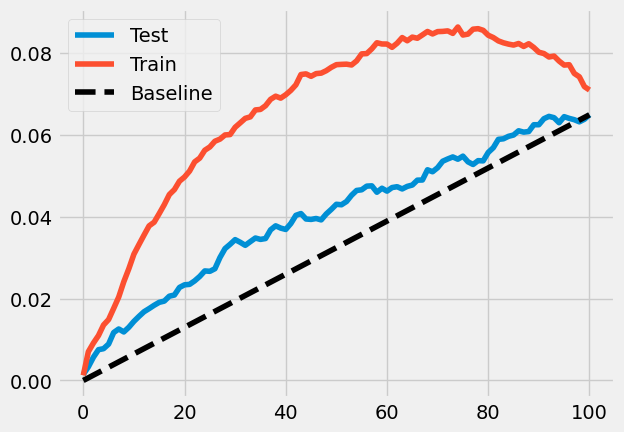

In [ ]:
gain_curve_test = cumulative_gain(test_pred, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(train.assign(cate=cate_learner.predict(train[X])), "cate", y="converted", t="em1")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
plt.legend();

Как мы видим, оценка «plug and play» лучше случайной на тестовом наборе. Тем не менее, похоже, что она сильно переобучается, поскольку её эффективность на обучающем наборе значительно выше, чем на тестовом.

На самом деле, это один из самых больших недостатков данного метода преобразования целевой выборки. Преобразование целевой выборки обеспечивает значительную простоту, поскольку позволяет просто преобразовать целевую выборку и использовать любую оценку ML для прогнозирования неоднородных эффектов воздействия. За это приходится платить высокой дисперсией. Это связано с тем, что преобразованная целевая выборка представляет собой очень зашумлённую оценку индивидуального эффекта воздействия, и эта дисперсия переносится на вашу оценку. Это серьёзная проблема, если у вас не так много данных, но она должна быть менее серьёзной в приложениях с большими данными, где вы имеете дело с более чем 1 млн выборок.

**Случай непрерывного воздействия**

Ещё один очевидный недостаток метода целевого преобразования заключается в том, что он работает только для дискретных или бинарных воздействий. Это часто встречается в литературе по причинно-следственным выводам. Большая часть исследований посвящена случаю бинарного воздействия, но о непрерывном воздействии информации мало. Matheus Facure придумал то, что работает на практике, хотя подчёркивает, что у него нет по-настоящему серьёзного эконометрического исследования по этому вопросу.

Чтобы проиллюстрировать это, вернёмся к примеру с продажей мороженого. Там нам была поставлена задача оценить эластичность спроса по цене, чтобы мы могли лучше устанавливать цены на мороженое для оптимизации наших доходов. Напомним, что выборка событий в наборе данных представляет собой день, и мы хотим знать, когда люди менее чувствительны к повышению цен. Кроме того, помните, что в этом наборе данных цены назначаются случайным образом, а это значит, что нам не нужно беспокоиться о смещении данных.

In [ ]:
prices_rnd = pd.read_csv("./data/ice_cream_sales_rnd.csv")
prices_rnd.head()

,temp,weekday,cost,price,sales
0,25.8,1,0.3,7,230
1,22.7,3,0.5,4,190
2,33.7,7,1.0,5,237
3,23.0,4,0.5,5,193
4,24.4,1,1.0,3,252


In [ ]:
np.random.seed(123)
train, test = train_test_split(prices_rnd, test_size=0.3)
train.shape, test.shape

((3500, 5), (1500, 5))

Сначала рассмотрим простой случай, когда результат линейен в зависимости от воздействия. Предположим, у нас есть два типа дней: жаркие (жёлтые) и холодные (синие). В холодные дни люди более чувствительны к росту цен. Кроме того, с ростом цен спрос линейно падает.

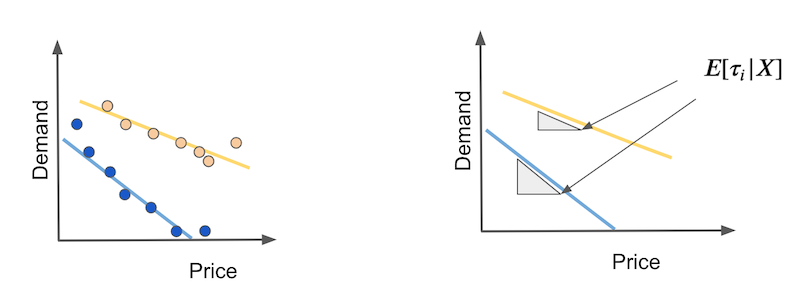

В этом случае CATE будет представлять собой наклон каждой линии спроса. Эти наклоны покажут нам, насколько упадёт спрос при любом повышении цены. Если эта зависимость действительно линейна, мы можем оценить эти эластичности с помощью коэффициента простой линейной регрессии отдельно для жарких и холодных дней.

$$
\hat{\tau(x)} = Cov(Y_i, T_i)/Var(T_i) = \dfrac{\sum(Y_i- \bar{Y})(T_i - \bar{T})}{\sum (T_i - \bar{T})^2}
$$

Вдохновившись этой оценкой, мы можем представить, как она будет выглядеть для отдельного объекта. Другими словами, что, если бы у нас было то же самое, заданное для каждого дня? Это было бы примерно так:

$
Y^*_i = (Y_i- \bar{Y})\dfrac{(T_i - \bar{T})}{\sigma^2_T}
$

Проще говоря, мы бы преобразовали исходную целевую величину, вычтя из неё среднее значение, затем умножив её на значение воздействия, из которого мы также вычли среднее значение. Наконец, мы бы разделили её на дисперсию воздействия. Вопрос теперь в следующем: работает ли это? На самом деле работает, и мы можем привести аналогичное доказательство, объясняющее, почему это работает, как и в двоичном случае.

Во-первых, обозначим $V_i = \dfrac{(T_i - \bar{T})}{\sigma^2_T}$. Обратите внимание, что $E[V_i|X_i=x]=0$, поскольку при случайном распределении $E[T_i|X_i=x]=\bar{T}$. Другими словами, для каждой области X $E[T_i]=\bar{T}$. Также $E[T_i V_i | X_i=x]=1$, поскольку $E[T_i(T_i - \bar{T})|X_i=x] = E[(T_i - \bar{T})^2|X_i=x]$, что является дисперсией воздействия. Наконец, при условной независимости (которую мы получаем бесплатно в случае случайного назначения воздействия), $E[T_i e_i | X_i=x] = E[T_i | X_i=x] E[e_i | X_i=x]$.

Чтобы показать, что это целевое преобразование работает, нам нужно помнить, что мы оцениваем параметр для локальной линейной модели $Y_i = \alpha + \beta T_i + e_i | X_i=x$.

В нашем примере это будут линейные модели для жарких и холодных дней. Здесь нас интересует параметр $\beta$, который является нашей условной эластичностью, или CATE. С учётом всего этого мы можем доказать, что

$
\begin{align}
E[Y^*_i|X_i=X] &= E[(Y_i-\bar{Y})V_i | X_i=x] \\
&= E[(\alpha + \beta T_i + e_i - \bar{Y})V_i | X_i=x] \\
&= \alpha E[V_i | X_i=x] + \beta E[T_i V_i | X_i=x] + E[e_i V_i | X_i=x] \\
&= \beta + E[e_i V_i | X_i=x] \\
&= \beta = \tau(x)
\end{align}
$

Помните, что это работает только при рандомизированном воздействии. Для нерандомизированного нам нужно заменить $\bar{T}$ на $M(X_i)$, где $M$ — это модель, которая оценивает $E[T_i|X_i=x]$.

$
Y^*_i = (Y_i- \bar{Y})\dfrac{(T_i - M(T_i))}{(T_i - M(T_i))^2}
$

Это гарантирует, что член $\alpha E[V_i | X_i=x]$ в третьей строке обратится в ноль, а член $E[T_i V_i | X_i=x]$ станет равен 1. Обратите внимание, что вам не обязательно стремиться к 1, если вы хотите упорядочить единицы по эффекту воздействия. Другими словами, если вы просто хотите узнать, в какие дни спрос более чувствителен к повышению цен, но вам не нужно знать, насколько, неважно, увеличены или уменьшены оценки $\beta$. В этом случае знаменатель можно опустить $Y^*_i = (Y_i- \bar{Y})(T_i - M(T_i))$.

Код на самом деле очень прост. Здесь у нас случайные назначения воздействия, поэтому нам не нужно строить модель, предсказывающую цены. Я также опускаю знаменатель, поскольку здесь меня интересует только порядок эффекта воздействия.

In [ ]:
y_star_cont = (train["price"] - train["price"].mean()) * (train["sales"] - train["sales"].mean())

cate_learner = LGBMRegressor(max_depth=3, min_child_samples=300, num_leaves=5)

np.random.seed(123)
cate_learner.fit(train[["temp", "weekday", "cost"]], y_star_cont)

cate_test_transf_y = cate_learner.predict(test[["temp", "weekday", "cost"]])

test_pred = test.assign(cate=cate_test_transf_y)
test_pred.sample(5)

На этот раз интерпретация CATE неинтуитивна. Поскольку мы убрали знаменатель из целевого преобразования, этот CATE, который мы видим, масштабируется по $Var(X)$. Тем не менее, этот прогноз должен довольно точно упорядочить эффект воздействия. Чтобы убедиться в этом, мы можем использовать кумулятивную кривую прироста, как и раньше.

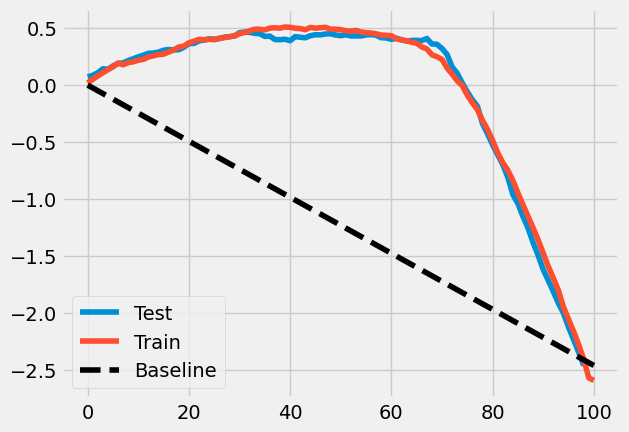

In [ ]:
gain_curve_test = cumulative_gain(test.assign(cate=cate_test_transf_y),
                                "cate", y="sales", t="price")

gain_curve_train = cumulative_gain(train.assign(cate=cate_learner.predict(train[["temp", "weekday", "cost"]])),
                                   "cate", y="sales", t="price")


plt.plot(gain_curve_test, label="Test")
plt.plot(gain_curve_train, label="Train")
plt.plot([0, 100], [0, elast(test, "sales", "price")], linestyle="--", color="black", label="Baseline")
plt.legend();

Для этих данных модель, похоже, намного лучше случайной. Более того, результаты обучения и тестирования довольно близки, поэтому дисперсия здесь не играет роли. Но это всего лишь характеристика данного набора данных. Если вы помните, в случае с бинарным воздействием этого не было. Там модель показала не очень хорошие результаты.

**Нелинейные эффекты воздействия**

Учитывая непрерывный случай, нам всё ещё нужно разобраться с проблемой. Мы предположили линейность эффекта воздействия. Однако это предположение крайне редко бывает обоснованным. Обычно эффекты воздействия достигают своего предела в той или иной форме. В нашем примере разумно предположить, что спрос будет снижаться быстрее при первых единицах повышения цены, но затем он будет падать медленнее.

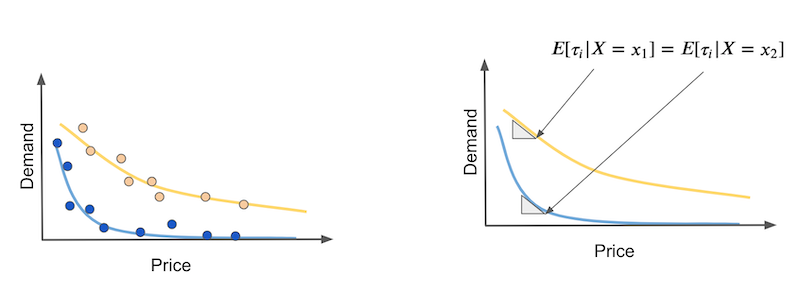

Проблема здесь в том, что **эластичность, или эффект воздействия, меняется вместе с самим воздействием**. В нашем примере эффект воздействия сильнее в начале кривой и ослабевает по мере роста цен. Предположим, что у вас есть два типа дней: жаркие (жёлтые) и холодные (синие), и мы хотим различить их с помощью причинно-следственной модели. Дело в том, что причинно-следственные модели должны предсказывать эластичность, но в нелинейном случае эластичность для жарких и холодных дней может быть одинаковой, если мы рассмотрим разные ценовые точки на кривой (правое изображение).

Простого решения этой проблемы нет. Matheus Facure предлагает представить функциональную форму эффекта воздействия и каким-то образом линеаризовать её. Например, спрос обычно имеет следующую функциональную форму, где более высокие значения $\alpha$s означают, что спрос падает быстрее с каждым повышением цены.

$
D_i = \dfrac{1}{P_i^{\alpha}}
$

Итак, если применить логарифмическое преобразование как к спросу $Y$, так и к ценам $T$, то должна получиться линейная функция.

$
\begin{align}
log(D)_i &= log\bigg(\dfrac{1}{P_i^{\alpha}}\bigg) \\
&= log(1) - log(P_i^{\alpha}) \\
&= log(1) - log(P_i^{\alpha}) \\
&= - \alpha * log(P_i) \\
\end{align}
$

Линеаризация не так проста, поскольку требует размышлений. Но вы можете попробовать разные варианты и найти лучший. Часто помогают такие методы, как логарифмы и квадратные корни.

#### Meta Learners

Напомним, что в настоящее время мы заинтересованы в выявлении неоднородности эффекта воздействия. В этой связи мы хотим оценить

$
\tau(x) = E[Y_i(1) − Y_i(0)|X] = E[\tau_i|X]
$

или, $E[\delta Y_i(t)|X]$ в непрерывном случае. Это очень полезно в тех случаях, когда мы не можем воздействовать на всех и нам нужно расставить приоритеты, например, когда вы хотите предоставлять скидки, но у вас ограниченный бюджет.

Ранее мы видели, как можно преобразовать целевую переменную $Y$, чтобы включить ее в прогностическую модель и получить условную среднюю оценку эффекта воздействия (CATE). За это нам пришлось заплатить ценой увеличения дисперсии.

Meta learners - это простой способ использовать готовые методы прогнозирующего машинного обучения для решения той же проблемы, которую мы рассматривали до сих пор: оценки CATE. Meta learners используют модели ML, которые могут варьироваться от линейной регрессии и деревьев решений до нейронных сетей и гауссовских процессов. Успех meta learner также во многом будет зависеть от того, какой метод машинного обучения он использует в качестве своих компонентов. Часто вам просто нужно попробовать много разных вещей и посмотреть, что работает лучше всего.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from toolz import curry

@curry
def elast(data, y, t):
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))

def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

Здесь мы будем использовать те же данные, что и раньше, повторно собирая электронные письма с инвестиционной рекламой. Цель здесь снова — выяснить, кто лучше отреагирует на электронное письмо. Однако есть небольшой нюанс. На этот раз мы будем использовать неслучайные данные для обучения моделей и случайные данные для их валидации. Работа с неслучайными данными — гораздо более сложная задача, поскольку метаобучающимся алгоритмам потребуется устранить смещение данных **И** оценить CATE.

In [ ]:
test = pd.read_csv("./data/invest_email_rnd.csv")
train = pd.read_csv("./data/invest_email_biased.csv")
train.head()

,age,income,insurance,invested,em1,em2,em3,converted
0,44.1,5483.80,6155.29,14294.81,0,0,1,0
1,39.8,2737.92,50069.40,7468.15,1,0,0,0
2,49.0,2712.51,5707.08,5095.65,0,0,1,1
3,39.7,2326.37,15657.97,6345.20,0,0,0,0
4,35.3,2787.26,27074.44,14114.86,1,1,0,0


In [ ]:
y = "converted"
T = "em1"
X = ["age", "income", "insurance", "invested"]

##### S-Learner

Первый алгоритм, который мы будем использовать, — это S-Learner. Это самый простой обучающийся алгоритм, который мы можем придумать. Мы будем использовать одну (отсюда и S) модель машинного обучения $M_s$ для оценки

$
\mu(x) = E[Y| T, X]
$

Для этого мы просто включим воздействие как признак в модель, которая пытается предсказать результат Y.

In [ ]:
from lightgbm import LGBMRegressor

np.random.seed(123)
s_learner = LGBMRegressor(max_depth=3, min_child_samples=30)
s_learner.fit(train[X+[T]], train[y]);

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 996
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 5
[LightGBM] [Info] Start training from score 0.200467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

Затем мы можем делать прогнозы при различных режимах воздействия. Разница в прогнозах между тестовой и контрольной группами будет нашей оценкой CATE.

$
\hat{\tau}(x)_i = M_s(X_i, T=1) - M_s(X_i, T=0)
$

Если представить это на диаграмме, то это будет выглядеть вот так:

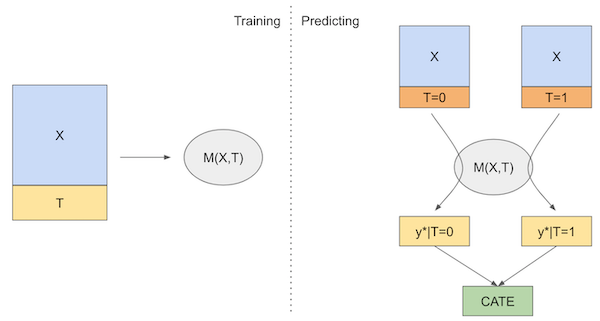

Теперь давайте посмотрим, как можно реализовать этот обучающий алгоритм в коде.

In [ ]:
s_learner_cate_train = (s_learner.predict(train[X].assign(**{T: 1})) -
                        s_learner.predict(train[X].assign(**{T: 0})))

s_learner_cate_test = test.assign(
    cate=(s_learner.predict(test[X].assign(**{T: 1})) - # predict under treatment
          s_learner.predict(test[X].assign(**{T: 0}))) # predict under control
)

Чтобы оценить эту модель, рассмотрим кумулятивную кривую прироста на тестовом наборе. Поскольку обучающий набор смещен, эта кривая не может дать никакого представления о качестве модели, но может указать на переобучение на обучающем наборе. В этом случае кривая на обучающем наборе будет очень высокой. Чтобы увидеть, как это выглядит, попробуйте изменить параметр `max_thought` с 3 на 20.

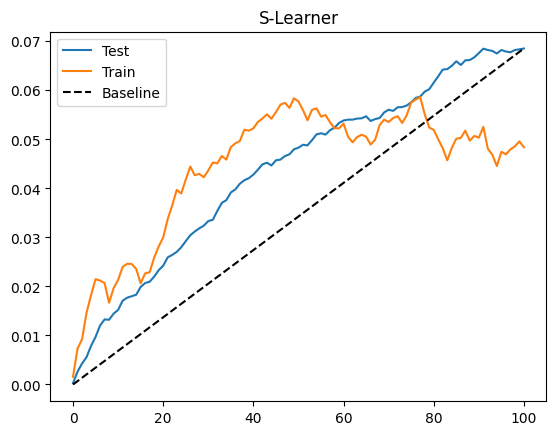

In [ ]:
gain_curve_test = cumulative_gain(s_learner_cate_test, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(train.assign(cate=s_learner_cate_train), "cate", y="converted", t="em1")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
plt.legend()
plt.title("S-Learner");

Как видно из совокупного прироста, алгоритм S-learner, несмотря на свою простоту, может работать на этом наборе данных достаточно хорошо. Следует помнить, что показатели сильно зависят от конкретного набора данных. В зависимости от типа данных, S-learner может работать лучше или хуже. На практике S-learner — хороший выбор для решения любой каузальной проблемы, главным образом благодаря своей простоте. Более того, S-learner может работать как с непрерывными, так и с дискретными воздействиями, в то время как многие другие learner алгоритмы работают только с дискретными.

Главный недостаток S-learner заключается в том, что он склонен стремиться к нулю при оценке эффекта воздействия. Поскольку S-learner обычно использует регуляризованную модель машинного обучения, эта регуляризация может ограничить предполагаемый эффект воздействия. Черножуков и др. (2016) описывают эту проблему, используя смоделированные данные:

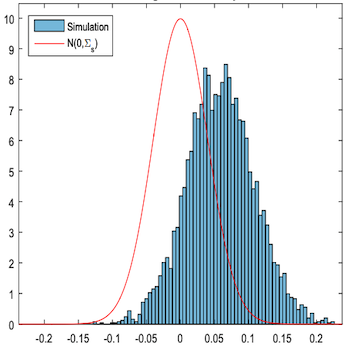

Здесь они строят график разницы между истинным причинно-следственным эффектом (красный контур) и расчётным причинно-следственным эффектом, $\tau - \hat{\tau}$, с использованием S-Learner'а. Расчётный причинно-следственный эффект сильно смещен.

Ещё хуже, если воздействие очень слабое по сравнению с влиянием других ковариатов на объяснение результата, S-обучающийся алгоритм может полностью отбросить воздействующую переменную. Обратите внимание, что это тесно связано с выбранной моделью машинного обучения. Чем выше регуляризация, тем серьёзнее проблема. Попытка исправить это — это следующий обучающийся алгоритм, который мы увидим.

##### T-Learner

T-learner пытается решить проблему полного исключения воздействия использованием вместо одной модели двух - по одной модели на каждую переменную воздействия. В бинарном случае нам нужно оценить только две модели (отсюда и название T):

$
\mu_0(x) = E[Y| T=0, X]
$

$
\mu_1(x) = E[Y| T=1, X]
$

Затем, во время прогнозирования, мы можем сделать контрфактуальные прогнозы для каждого воздействия и получить CATE следующим образом.

$
\hat{\tau}(x)_i = M_1(X_i) - M_0(X_i)
$

Вот схема этого алгоритма

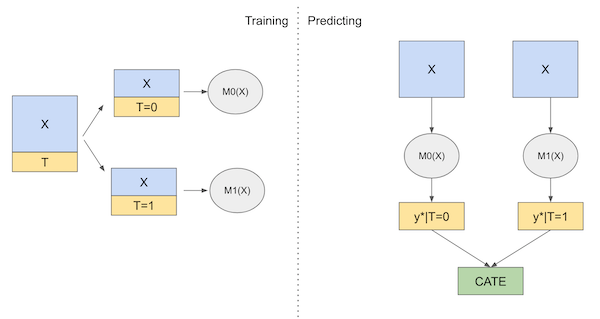

In [ ]:
np.random.seed(123)

m0 = LGBMRegressor(max_depth=2, min_child_samples=60)
m1 = LGBMRegressor(max_depth=2, min_child_samples=60)

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])

# estimate the CATE
t_learner_cate_train = m1.predict(train[X]) - m0.predict(train[X])
t_learner_cate_test = test.assign(cate=m1.predict(test[X]) - m0.predict(test[X]))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 11630, number of used features: 4
[LightGBM] [Info] Start training from score 0.189596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

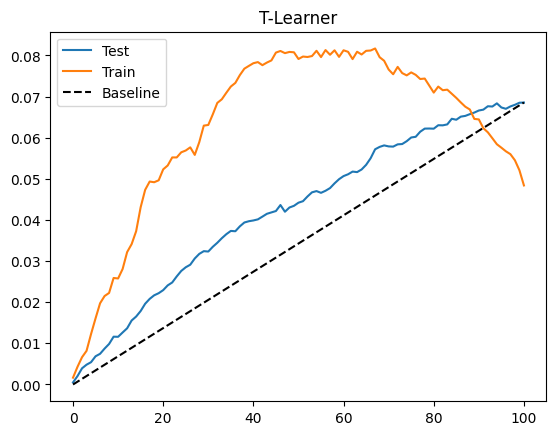

In [ ]:
gain_curve_test = cumulative_gain(t_learner_cate_test, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(train.assign(cate=t_learner_cate_train), "cate", y="converted", t="em1")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("T-Learner");

T-learner также показывает неплохие результаты на этом наборе данных. Результаты на тестовых данных не сильно отличаются от результатов S-learner. Возможно, это связано с тем, что воздействие не такое уж слабое. Кроме того, мы видим, что результаты на обучающем датасете значительно выше результатов на тестовом. Это указывает на переобучение модели. Это может происходить из-за того, что мы подгоняем каждую модель только к подмножеству данных. При меньшем количестве точек данных модель, вероятно, обучается с некоторым шумом.

T-learner избегает проблемы нераспознавания слабой переменной воздействия, но всё же может страдать от смещения регуляризации. Рассмотрим следующую ситуацию, взятую из работы Kunzela et al, 2019. У вас много данных из контрольной группы и очень мало данных из тестовой, что довольно распространённый случай во многих приложениях, поскольку воздействие часто требует больших затрат. Теперь предположим, что у вас есть некоторая нелинейность в результате Y, но **эффект воздействия постоянен**. Что происходит, можно увидеть на следующем изображении.

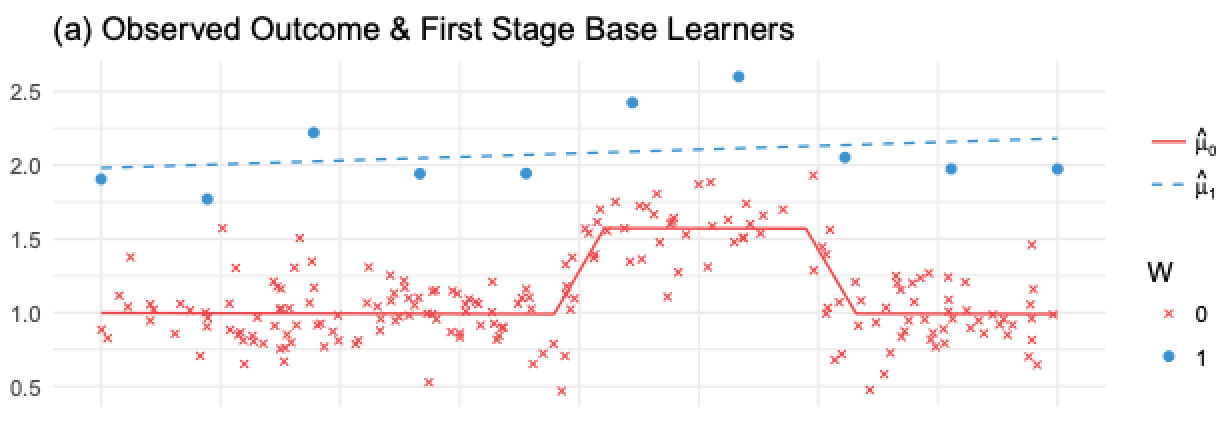

Здесь, поскольку у нас очень мало тестовых наблюдений, $M_1$ будет очень простой моделью (в данном случае линейной), чтобы избежать переобучения. $M_0$ будет сложнее, но это нормально, поскольку обилие данных предотвращает переобучение. Всё это разумно с точки зрения машинного обучения. Однако, если мы используем эти модели для вычисления категоризации $\hat{\tau}=M_1(X) - M_0(X)$, линейность $M_1(X)$ минус нелинейность $M_0(X)$ приведёт к нелинейному CATE (синяя линия минус красная линия), что неверно, поскольку CATE в данном случае постоянна и равна 1.

В данном случае происходит следующее: модель для данных из контрольной группы может уловить нелинейность, а модель для данных с тестовой группы — нет, поскольку мы использовали регуляризацию для работы с небольшой выборкой. Конечно, можно было бы использовать меньшую регуляризацию для этой модели, но тогда малый размер выборки приведёт к переобучению. Похоже, мы оказались между молотом и наковальней. Для решения этой проблемы можно использовать X-learner, предложенный в той же статье.

##### X-Learner

X-learner значительно сложнее объяснить, чем предыдущий, но его реализация довольно проста, так что не волнуйтесь. X-learner состоит из двух этапов и модели оценки propensity score. Первый этап идентичен T-learner. Сначала мы разделяем данные на тестовые и контрольные и подбираем ML модель для каждой из выборки.

$
\hat{M}_0(X) \approx E[Y| T=0, X]
$

$
\hat{M}_1(X) \approx E[Y| T=1, X]
$

Теперь всё меняется. На втором этапе мы вычисляем эффект воздействия для контрольной и экспериментальной группы, используя описанные выше модели.

$
\hat{\tau}(X, T=0) = \hat{M}_1(X, T=0) - Y_{T=0}
$

$
\hat{\tau}(X, T=1) = Y_{T=1} - \hat{M}_0(X, T=1)
$

Затем мы подбираем две дополнительные модели для прогнозирования этих эффектов.

$
\hat{M}_{\tau 0}(X) \approx E[\hat{\tau}(X)|T=0]
$

$
\hat{M}_{\tau 1}(X) \approx E[\hat{\tau}(X)|T=1]
$

Если применить это к показанному изображению, ранее $\hat{\tau}(X, T=0)$, импутированный эффект воздействия на контрольную выборку, был бы обозначен красными крестиками, а красная пунктирная линия — $\hat{M}_{\tau 0}(X)$. Обратите внимание, что эта модель неверна. Поскольку $\hat{\tau}(X, T=0)$ была создана с использованием регуляризованной простой модели, оцененной на тестовой выборке $\hat{M}_1$. Импутируемый эффект воздействия нелинейный, поскольку он **не** учитывает нелинейность переменной $Y$.

Напротив, синие точки — это эффект воздействия на тестовую выборку $\hat{\tau}(X, T=1)$. Эти эффекты оцениваются с помощью корректной модели $M_0$, обученной на большой контрольной выборке. В результате, поскольку вменённые эффекты воздействия верны, мы можем обучить корректную модель второго этапа $\hat{M}_{\tau 1}(X)$, показанную синей линией.

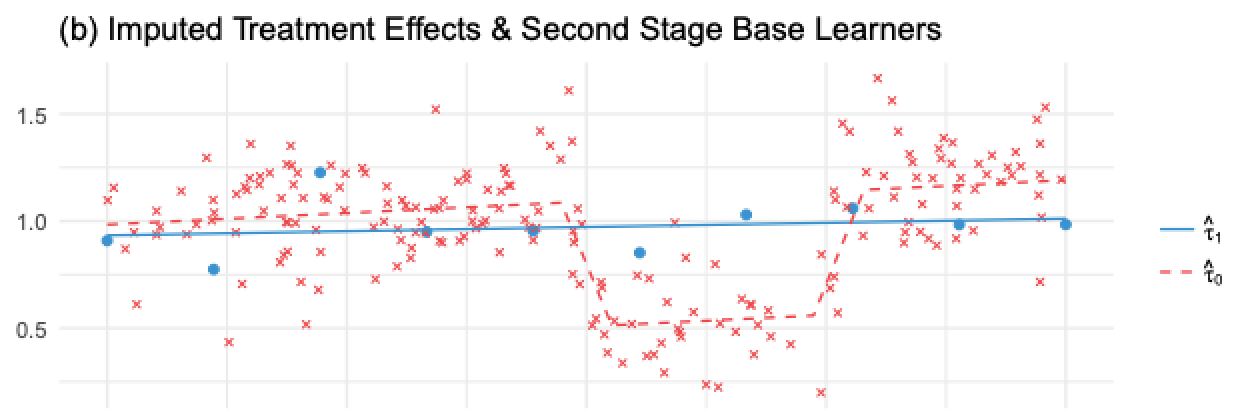

Итак, у нас есть одна модель, которая неверна, поскольку мы неверно вменили эффекты воздействия, и другая, которая верна, поскольку мы правильно вменили эти значения. Теперь нам нужно найти способ объединить эти две модели таким образом, чтобы придать больший вес корректной модели. Здесь вступает в игру модель с propensity score $\hat{e}(x)$. Мы можем объединить две модели второго этапа следующим образом:

$
\hat{\tau(x)} = \hat{M}_{\tau 0}(X)\hat{e}(x) + \hat{M}_{\tau 1}(X)(1-\hat{e}(x))
$

Поскольку количество обработанных единиц очень мало, $\hat{e}(x)$ очень мало. Это даст очень малый вес неверной модели $\hat{M}_{\tau 0}(X)$.

Напротив, $1-\hat{e}(x)$ близко к единице, поэтому верной модели $\hat{M}_{\tau 1}(X)$ будет присвоен высокий вес. В более общем смысле, взвешенное среднее с использованием propensiyt score гарантирует, что мы придадим больший вес модели CATE, которая была оценена в случае, когда назначенное воздействие было более вероятным. Другими словами, мы отдадим предпочтение модели, обученной на большем количестве данных. На следующем изображении показаны расчетные значения CATE, полученные с помощью X-learner и T-learner.

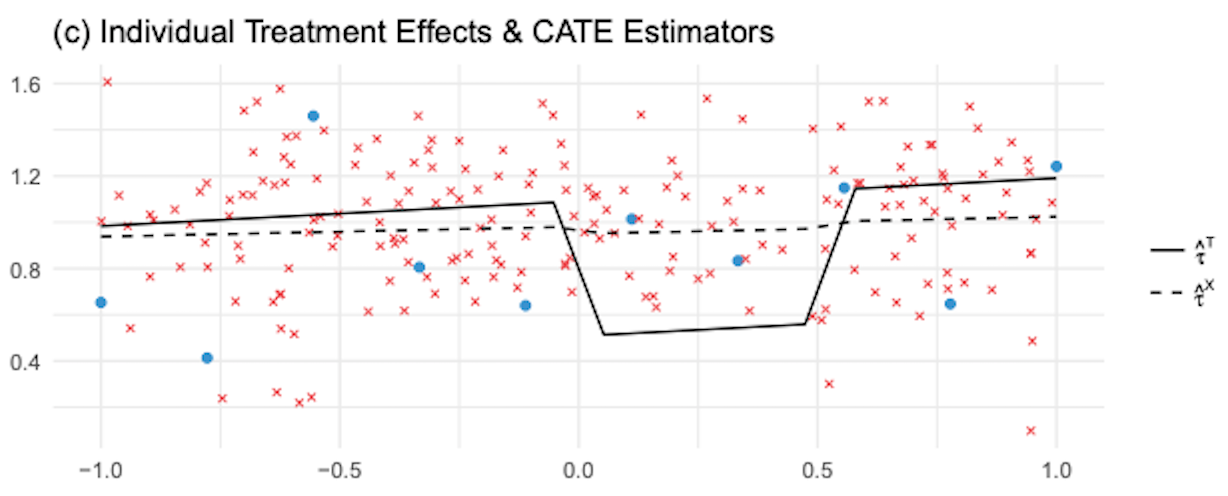

Как мы видим, по сравнению с T-learner, X-learner гораздо лучше справляется с исправлением неверного значения CATE, оцененного с учетом нелинейности.

Подводя итог, вот схема этого обучающегося алгоритма.

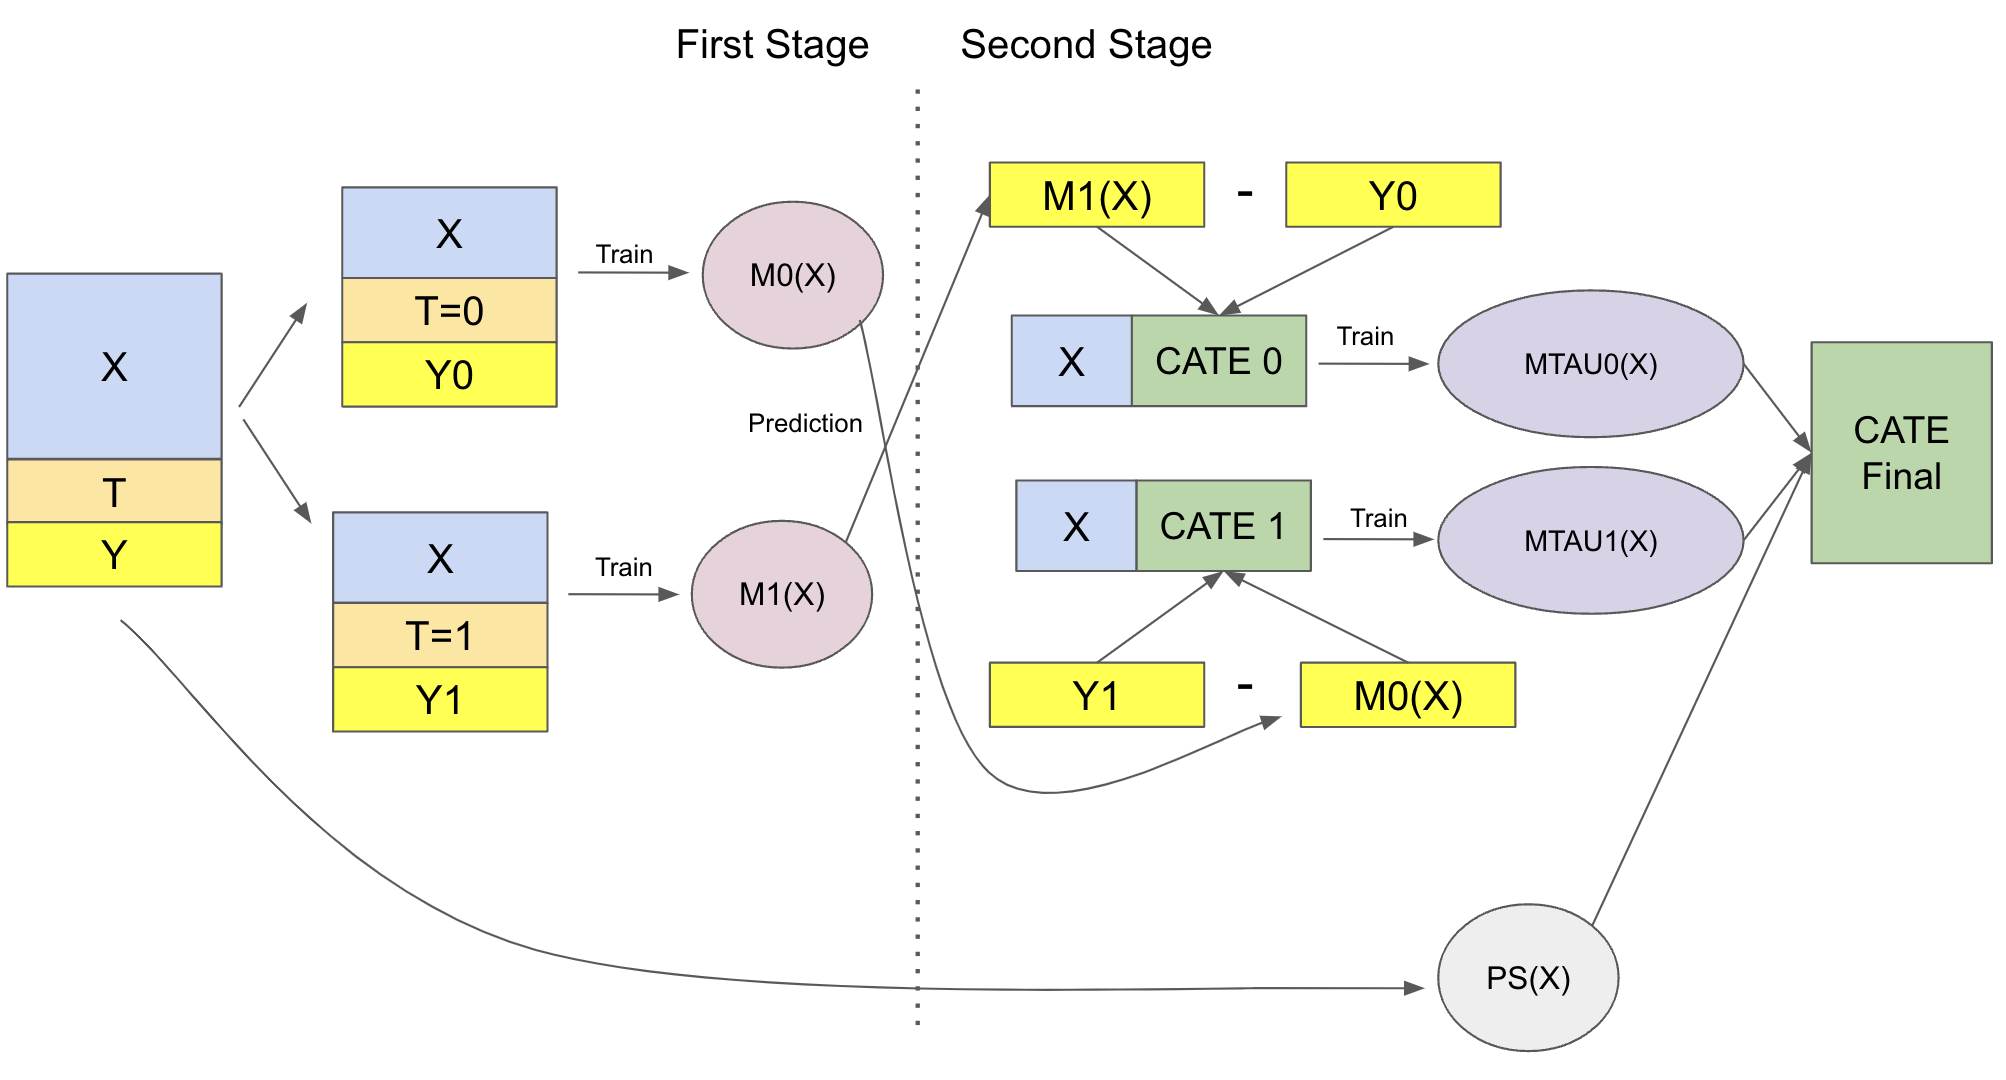

Наконец-то к коду! Сначала у нас есть первый этап, который в точности совпадает с T-Learner.

In [ ]:
from sklearn.linear_model import LogisticRegression

np.random.seed(123)

# first stage models
m0 = LGBMRegressor(max_depth=2, min_child_samples=30)
m1 = LGBMRegressor(max_depth=2, min_child_samples=30)

# propensity score model
g = LogisticRegression(solver="lbfgs")

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])

g.fit(train[X], train[T])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 11630, number of used features: 4
[LightGBM] [Info] Start training from score 0.189596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

Теперь мы учитываем эффект воздействия и подгоняем под него модели второго этапа.

In [ ]:
d_train = np.where(train[T]==0,
                   m1.predict(train[X]) - train[y],
                   train[y] - m0.predict(train[X]))

# second stage
mx0 = LGBMRegressor(max_depth=2, min_child_samples=30)
mx1 = LGBMRegressor(max_depth=2, min_child_samples=30)

mx0.fit(train.query(f"{T}==0")[X], d_train[train[T]==0])
mx1.fit(train.query(f"{T}==1")[X], d_train[train[T]==1]);

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 11630, number of used features: 4
[LightGBM] [Info] Start training from score 0.107760
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

Наконец, мы делаем скорректированные прогнозы, используя модель propensity score.

In [ ]:
def ps_predict(df, t):
    return g.predict_proba(df[X])[:, t]


x_cate_train = (ps_predict(train,1)*mx0.predict(train[X]) +
                ps_predict(train,0)*mx1.predict(train[X]))

x_cate_test = test.assign(cate=(ps_predict(test,1)*mx0.predict(test[X]) +
                                ps_predict(test,0)*mx1.predict(test[X])))

Давайте посмотрим, как наш X-Learner справится с тестом. Снова построим кривую накопленного прироста.

/tmp/ipython-input-1069938332.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /


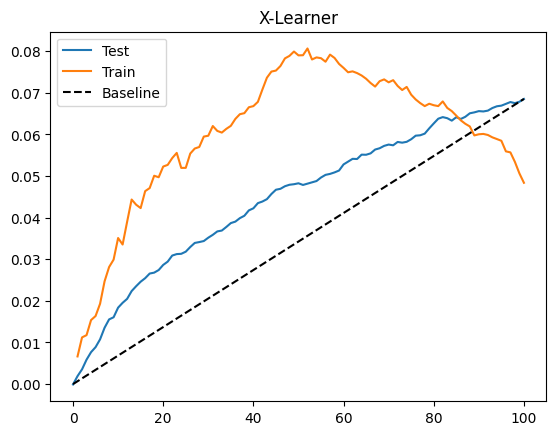

In [ ]:
gain_curve_test = cumulative_gain(x_cate_test, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(train.assign(cate=x_cate_train), "cate", y="converted", t="em1")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("X-Learner");

И снова, на этом наборе данных у нас приемлемое качество. Здесь S-, T- и X- Learner'ы, похоже, показывают примерно одинаковые результаты. Имейте в виду, что производительность также сильно зависит от выбранной базовой модели машинного обучения. Здесь мы всё сделали с помощью градиентного бустинга, но, возможно, что-то другое или даже то же самое с другими гиперпараметрами может подойти лучше.

#### Debiased ML

Что делает его таким особенным, что он заслуживает отдельной главы, помимо других мета-мета-обучающихся? Меня привлекло то, насколько хорошо обоснован этот метод машинного обучения с дебивазированным/ортогональным кодом. Другие методы, которые мы рассматривали до сих пор, T-learner, S-learner и X-learner, кажутся немного хакерскими. Мы можем дать интуитивное объяснение их работы, но они не кажутся слишком общими. В отличие от этого, с ортогональным машинным обучением у нас есть общая структура, которую мы можем применять, которая одновременно очень интуитивна и очень строга. Ещё одним преимуществом является то, что ортогональное машинное обучение работает как для непрерывных, так и для дискретных данных, чего не могут сделать ни T-, ни X-Learner'ы. Не говоря уже о том, что в статьях, описывающих его, проделана невероятная работа с асимптотическим анализом этой оценки. Итак, без лишних слов, давайте приступим к делу.

В очередной раз, в качестве мотивирующего примера, мы обратимся к набору данных о продажах мороженого. Напоминаем, что здесь мы пытаемся выявить неоднородность влияния цены на продажи. В нашем тестовом наборе цены были назначены случайным образом, а в обучающих данных — только цены, полученные в результате наблюдений, что потенциально смещено.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import style
style.use("ggplot")

from toolz import curry

@curry
def elast(data, y, t):
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))

def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

In [18]:
test = pd.read_csv("ice_cream_sales_rnd.csv")
train = pd.read_csv("ice_cream_sales.csv")
train.head()

,temp,weekday,cost,price,sales
0,17.3,6,1.5,5.6,173
1,25.4,3,0.3,4.9,196
2,23.3,5,1.5,7.6,207
3,26.9,1,0.3,5.3,241
4,20.2,1,1.0,7.2,227


<Axes: xlabel='price', ylabel='sales'>

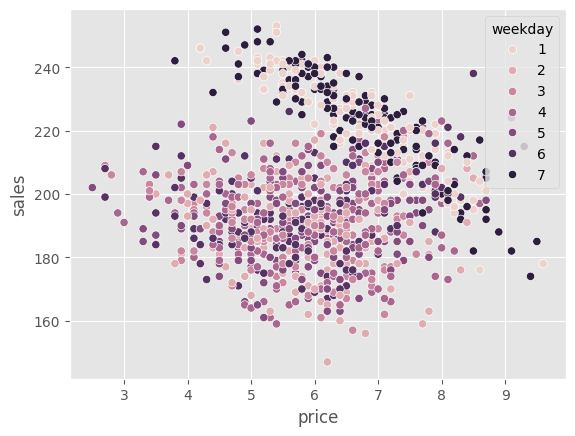

In [3]:
np.random.seed(123)
sns.scatterplot(data=train.sample(1000), x="price", y="sales", hue="weekday")

Один из источников смещения совершенно очевиден. Как мы видим, цены значительно выше в выходные дни (дни 1 и 7), но у нас также могут быть другие факторы, влияющие на результаты, такие как температура и стоимость. Поэтому, если мы хотим сделать какой-либо причинно-следственный вывод, нам необходимо скорректировать это смещение.

Один из способов устранения этого смещения — использование линейной модели для оценки влияния воздействия цен на продажи с учетом влияния факторов, влияющих на результаты.

$$
Sales_i = \alpha + \tau price_i + \beta_1 temp_i + \beta_2 cost_i + \pmb{\beta_3} Weekday_i + e_i
$$

где $\pmb{\beta_3}$ — вектор параметров, связанных с каждым фиктивным днём недели.

Обратите внимание, что нас интересует только параметр $\tau$, поскольку он отражает влияние воздействия. Но даже если остальные параметры нам неинтересны, нам нужно правильно их учесть, иначе эффект от воздействия будет оценен неправильно.

Например, если задуматься, зависимость между `temp` и продажами, вероятно, нелинейна. Сначала, с повышением температуры, больше людей будут ходить на пляж и покупать мороженое, поэтому продажи вырастут. Но в какой-то момент станет слишком жарко, и люди решат, что лучше остаться дома. В этот момент продажи упадут. Зависимость между `temp` и продажами, вероятно, достигает пика, а затем снижается. Это означает, что приведенная выше модель, вероятно, неверна. Должно было быть что-то вроде

$$
Sales_i = \alpha + \tau price_i + \beta_1 temp_i + \beta_2 temp^2_i + \beta_3 cost_i + \pmb{\beta_4} Weekday_i + e_i
$$

с квадратичным членом.

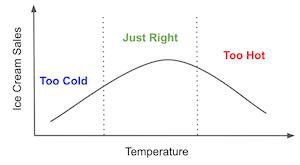

Размышлять о том, как моделировать мешающие параметры, имея всего несколько ковариатов, не сильно интересно. Но что, если бы их было десятки или сотни? С современными наборами данных это довольно распространенное явление. Итак, что мы можем с этим поделать? Ответ кроется в  крутой эконометрической теореме.

**Фриш-Во-Ловелл**

Фриш, Во и Ловелл были эконометристами XX века, которые заметили удивительную особенность линейной регрессии. Это для вас не новость, поскольку мы уже обсуждали это в контексте остатков регрессии и при обсуждении фиксированных эффектов. Но поскольку эта теорема играет ключевую роль в понимании ортогонального ML, её стоит повторить.

Предположим, у вас есть модель линейной регрессии с набором признаков $X_1$ и другим набором признаков $X_2$. Затем вы оцениваете параметры этой модели.

$
\hat{Y} = \hat{\beta_1} X_1 + \hat{\beta_2} X_2
$

где $X_1$ и $X_2$ — матрицы признаков, а $\hat{\beta_1}$ и $\hat{\beta_2}$ — векторы-строки. Вы можете получить точно такой же параметр $\hat{\beta_1}$, выполнив следующие шаги:

1. Регрессия результата $y$ по второму набору признаков $\hat{y^*} = \hat{\gamma_1} X_2$
2. Регрессия первого набора признаков по второму $\hat{X_1} = \hat{\gamma_2} X_2$
3. Получение остатков $\tilde{X}_1 = X_1 - \hat{X_1}$ и $\tilde{y}_1 = y - \hat{y^*}$
4. Регрессия остатков результата по остаткам признаков $\tilde{y} = \hat{\beta_1} \tilde{X}_1$

Это невероятно круто. Здесь у нас есть обобщенное представление, но обратите внимание, что один набор признаков может быть просто переменной воздействия. Это означает, что вы можете оценить все мешающие параметры отдельно. Сначала регрессируем результат по признакам, чтобы получить остатки результата. Затем регрессируем воздействие по признакам, чтобы получить остатки воздействия. Наконец, регрессируем остатки результата по остаткам признаков. Это даст точно такую же оценку, как если бы мы регрессировали результат по признакам и воздействию одновременно.

Другими словами, эффект воздействия можно вывести из **регрессии на остатки**, где мы получаем остатки регрессии $Y$ на $X$ и регрессируем их на остатки регрессии $T$ на $X$. Предположим, что $\sim$ — оператор регрессии, поэтому теорему ФВЛ можно сформулировать следующим образом.

$
(Y - (Y \sim X)) \sim (T - (T \sim X))
$

что, по сути, представляет собой оценку параметра $\tau$ в следующей модели:

$
Y_i - E[Y_i | X_i]
= \tau \cdot (T_i - E[T_i | X_i]) + \epsilon
$

Метод ФВЛ настолько хорош, что позволяет нам разделить процедуру оценки причинного параметра и мешающих параметров. Но мы так и не ответили на наш первоначальный вопрос: как избежать всех этих сложностей, связанных с указанием правильной функциональной формы для мешающих параметров? Или, другими словами, как сосредоточиться только на причинном параметре, не беспокоясь о мешающих параметрах? Вот тут-то и вступает в игру машинное обучение.

**Frisch-Waugh-Lovell на стероидах**

Double/Debiased ML можно рассматривать как теорему Фриша, Во и Ловелла на стероидах. Идея очень проста: использовать ML модели при построении остатков исхода и воздействия:

$
Y_i - \hat{M}_y(X_i)
= \tau \cdot (T_i - \hat{M}_t(X_i)) + \epsilon
$

Где $\hat{M}_y(X_i)$ оценивает $E[Y|X]$, а $\hat{M}_t(X_i)$ оценивает $E[T|X]$.

Идея заключается в том, что ML модели очень гибкие, поэтому они могут учитывать взаимодействия и нелинейности при оценке остатков $Y$ и $T$, сохраняя при этом ортогонализацию в стиле FWL. Это означает, что нам не нужно делать никаких параметрических предположений о связи между ковариатами $X$ и результатом $Y$, а также между ковариатами и воздействием, чтобы получить правильный эффект. При отсутствии ненаблюдаемых факторов, влияющих на результаты, мы можем восстановить ATE с помощью следующей процедуры ортогонализации:

1. Оценить результат $Y$ с признаками $X$, используя гибкую модель регрессии $M_y$.
2. Оценить воздействие $T$ с признаками $X$, используя гибкую модель регрессии $M_t$.
3. Получить остатки $\tilde{Y} = Y - M_y(X)$ и $\tilde{T} = T - M_t(X)$
4. Регрессия остатков исхода на остатки воздействия $\tilde{Y} = \alpha + \tau \tilde{T}$

где $\tau$ — причинно-следственный параметр ATE, который можно оценить, например, с помощью МНК.

Преимущество ML заключается в гибкости. ML настолько мощно, что может улавливать сложные функциональные формы в мешающем взаимодействии. Но эта гибкость также вызывает трудности, поскольку означает, что теперь нам приходится учитывать возможность переобучения.

В работе Черножукова и др. (2016) представлено гораздо более глубокое и строгое объяснение того, как переобучение может быть проблематичным, и я настоятельно рекомендую вам с ним ознакомиться. Здесь же я продолжу с более интуитивным объяснением.

Чтобы увидеть проблему, предположим, что ваша модель $M_y$ переобучена. В результате остаток $\tilde{Y}$ будет меньше, чем должен быть. Это также означает, что $M_y$ учитывает не только взаимосвязь между $X$ и $Y$. Частью этой взаимосвязи является взаимосвязь между $T$ и $Y$, и если $M_y$ учитывает её, регрессия остатка будет смещена в сторону нуля. Другими словами, $M_y$ учитывает причинно-следственную связь, не перекладывая её на итоговую регрессию остатка.

Теперь, чтобы увидеть проблему переобучения $M_t$, обратите внимание, что она объясняет большую часть дисперсии $T$, чем должна. В результате остаток воздействия будет иметь меньшую дисперсию, чем должна быть. Если дисперсия воздействия меньше, дисперсия итоговой оценки будет высокой. Как будто воздействие одинаково для почти всех. А если у всех одинаковый уровень воздействия, становится очень сложно оценить, что произойдёт при разных уровнях воздействия. Кстати, то же самое произойдёт и в случае, когда $T$ является детерминированной функцией $X$, что означает нарушение положительности.

Это проблемы, с которыми мы сталкиваемся при использовании ML моделей, но как их исправить? Ответ кроется в том, что мы будем называть cross prediction and out-of-fold остатками.

![img](./data/img/debiased-ml/cross-prediction.png)

Мы разделим данные на K частей одинакового размера. Затем для каждой части k мы оценим ML модели на всех остальных выборках K-1 и рассчитаем остатки для части k. Обратите внимание, что эти остатки получены с помощью out-of-fold prediction. Мы подгоняем модель по одной части данных, но делаем прогнозы и остатки по другой.

поэтому даже если модель переобучается, она не будет искусственно сводить остатки к нулю. Наконец, мы объединяем прогнозы по всем частям K, чтобы оценить окончательную причинно-следственную модель $\tilde{Y} = \alpha + \tau \tilde{T}$.

Итак, мы рассмотрели много материала, и без примера может быть сложно уследить за ним. Чтобы подкрепить всю эту теорию, давайте шаг за шагом рассмотрим реализацию Double/Debiased ML. По мере этого я воспользуюсь возможностью объяснить, что делает каждый шаг.

Сначала оценим модель воздействия $M_t$. Мы будем использовать модель LGBM для прогнозирования цен на основе ковариатов `temp`, `weekday` и `cost`. Эти прогнозы будут перекрёстными, которые мы можем получить с помощью функции `cross_val_predict` из `sklearn`. Я также добавляю среднее значение $\hat{\mu_t}$ к остаткам для наглядности.

In [4]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_predict

y = "sales"
T = "price"
X = ["temp", "weekday", "cost"]

debias_m = LGBMRegressor(max_depth=3)

train_pred = train.assign(price_res =  train[T] -
                          cross_val_predict(debias_m, train[X], train[T], cv=5)
                          + train[T].mean()) # add mu_t for visualization.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 3
[LightGBM] [Info] Start training from score 6.132825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

Обратите внимание, что я называю модель $M_t$ debias. Это связано с тем, что роль этой модели в модели Double/Debias ML заключается в устранении смещения в воздействии. Остатки $\tilde{T} = T - M_t(X)$ можно рассматривать как вариант воздействия, в котором все смешивающие смещения от $X$ были устранены моделью. Другими словами, $\tilde{T}$ ортогональна $X$. Интуитивно понятно, что $\tilde{T}$ больше не может быть объяснена $X$, поскольку она уже была таковой.

Чтобы увидеть это, мы можем показать тот же график, что и раньше, но теперь заменив цену на остатки цены. Помните, что раньше в выходные цены были выше? Теперь это смещение исчезло. Все будние дни имеют одинаковое распределение остатков цены.

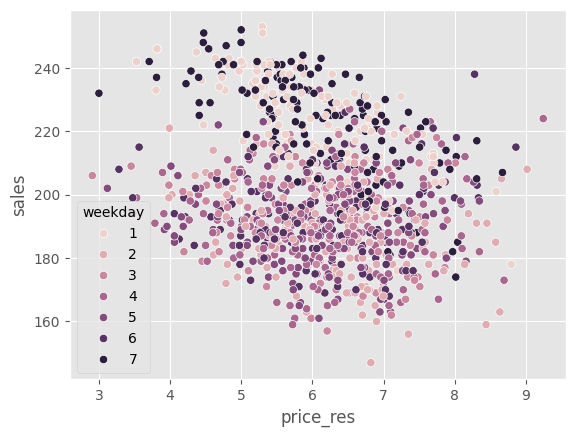

In [5]:
np.random.seed(123)
sns.scatterplot(data=train_pred.sample(1000), x="price_res", y="sales", hue="weekday");

Роль $M_t$ заключается в устранении смещения при обработке, но как насчёт $M_y$? Её роль — устранить дисперсию из $Y$. Интуитивно понятно, что $M_y$ создаёт версию результата, в которой вся дисперсия, вызванная $X$, устранена. В результате становится проще проводить причинно-следственную оценку в $\tilde{Y}$. Поскольку шума меньше, причинно-следственную связь становится легче увидеть.

In [6]:
denoise_m = LGBMRegressor(max_depth=3)

train_pred = train_pred.assign(sales_res =  train[y] -
                               cross_val_predict(denoise_m, train[X], train[y], cv=5)
                               + train[y].mean())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 3
[LightGBM] [Info] Start training from score 200.473000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

Если мы построим тот же график, что и раньше, но теперь заменим продажи на остатки продаж, то увидим, что отклонение $Y$ стало намного меньше, чем было раньше.

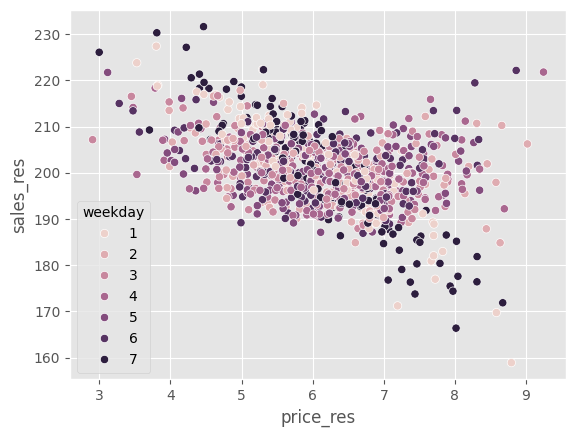

In [7]:
np.random.seed(123)
sns.scatterplot(data=train_pred.sample(1000), x="price_res", y="sales_res", hue="weekday");

Теперь легко увидеть отрицательную связь между ценами и продажами.

Наконец, чтобы оценить эту причинно-следственную связь, мы можем провести регрессию по остаткам.

In [8]:
final_model = smf.ols(formula='sales_res ~ price_res', data=train_pred).fit()
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:              sales_res   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     3021.
Date:                Sat, 23 Aug 2025   Prob (F-statistic):               0.00
Time:                        11:07:17   Log-Likelihood:                -33949.
No. Observations:               10000   AIC:                         6.790e+04
Df Residuals:                    9998   BIC:                         6.792e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    224.5586      0.443    506.469      0.0

Как мы видим, используя ортогональную версию продаж и цены, мы можем быть уверены, что связь между ценами и продажами отрицательная, что вполне логично. По мере повышения цен спрос на мороженое должен падать.

Но если мы посмотрим на исходную версию связи между ценами и продажами, то из-за смещения мы обнаружим положительную связь. Это связано с тем, что в преддверии высоких продаж цены повышаются.

In [9]:
final_model = smf.ols(formula='sales ~ price', data=train_pred).fit()
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     57.38
Date:                Sat, 23 Aug 2025   Prob (F-statistic):           3.90e-14
Time:                        11:08:19   Log-Likelihood:                -43825.
No. Observations:               10000   AIC:                         8.765e+04
Df Residuals:                    9998   BIC:                         8.767e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    192.9679      1.013    190.414      0.0

**Оценка CATE с помощью Double-ML**

До сих пор мы видели, как Double-ML позволяет нам сосредоточиться на оценке среднего эффекта воздействия (ATE), но его также можно использовать для оценки гетерогенности эффекта воздействия (CATE). По сути, теперь мы говорим, что причинно-следственный параметр $\tau$ изменяется в зависимости от ковариатов единицы.

$
Y_i - {M}_y(X_i)
= \tau(X_i) \cdot (T_i - {M}_t(X_i)) + \epsilon_i
$

Для оценки этой модели мы будем использовать ту же версию цены и продаж с остатками, но теперь мы будем взаимодействовать с остатками цен и с другими ковариатами. Затем мы можем подогнать линейную модель CATE.

$
\tilde{Y_i} = \alpha + \beta_1 \tilde{T_i} + \pmb{\beta}_2 \pmb{X_i} \tilde{T_i} + \epsilon_i
$

После оценки такой модели для построения прогнозов CATE мы будем использовать рандомизированный тестовый набор. Поскольку эта окончательная модель линейна, мы можем вычислить CATE механически:

$
\hat{\mu}(\partial Sales_i, X_i) = M(Price=1, X_i) - M(Price=0, X_i)
$

где $M$ — наша окончательная линейная модель

In [19]:
final_model_cate = smf.ols(formula='sales_res ~ price_res * (temp + C(weekday) + cost)', data=train_pred).fit()

cate_test = test.assign(cate=final_model_cate.predict(test.assign(price_res=1))
                        - final_model_cate.predict(test.assign(price_res=0)))

Чтобы проверить, насколько хороша эта модель с точки зрения дифференциации единиц с высокой ценовой чувствительностью от единиц с низкой ценовой чувствительностью, мы воспользуемся кумулятивной кривой эластичности.

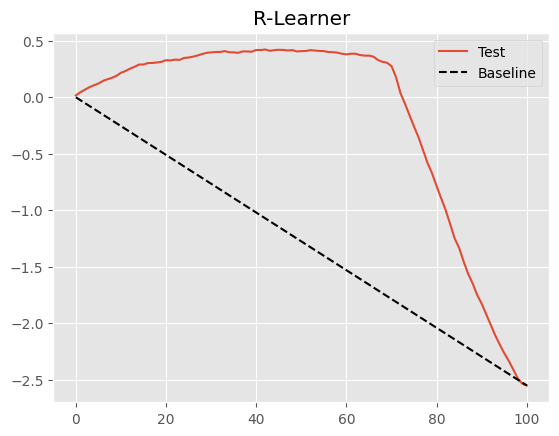

In [20]:
gain_curve_test = cumulative_gain(cate_test, "cate", y=y, t=T)
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("R-Learner");

Процедура Double/Debiased ML с итоговой линейной моделью уже очень хороша, как видно по кривой выше. Но, возможно, мы сможем добиться ещё большего. На самом деле, это очень общая процедура, которую мы можем понять так же, как и Meta-Learner'ы. Най и Вейджер назвали её R-Learner, чтобы отметить работу Робинсона (1988) и подчеркнуть роль остаточного обучения.

Это обобщение исходит из понимания того, что процедура Double/Debiased ML определяет новую функцию потерь, которую мы можем минимизировать любым желаемым образом. Далее мы рассмотрим, как это сделать, очень похоже на то, что мы видели ранее при обсуждении преобразования целевой метрики.

**Непараметрический Double/Debiased ML**

Преимущество Double-ML заключается в том, что он освобождает нас от всех хлопот, связанных с изучением мешающих параметров в причинно-следственной модели. Благодаря этому мы можем сосредоточить всё внимание на изучении интересующего нас причинно-следственного параметра, будь то ATE или CATE. Однако с приведённой выше спецификацией мы всё ещё использовали линейную модель после ML-остаточности в качестве окончательной причинно-следственной модели. В нашем примере это означает, что мы предполагаем, что цена влияет на продажи линейно. Вероятно, это приемлемо для небольшого диапазона цен, но из микроэкономической теории мы знаем, что это не обязательно так. Возможно, при низких ценах повышение цены на единицу снизит спрос на 2 единицы. Но затем, при более высоких ценах, повышение цены на единицу снизит спрос всего на 1 единицу. Это нелинейная зависимость.

Мы могли бы использовать микроэкономическую теорию, чтобы рассуждать о функциональной форме результата воздействия, но, возможно, мы также можем делегировать это ML модели. Другими словами, позвольте модели освоить эту сложную форму функции. Как оказалось, это вполне возможно, если мы внесем несколько изменений в наш исходный Double/Debiased ML алгоритм.

Сначала мы начинаем точно так же, как и раньше, ортогонализируя воздействие и результат с помощью перекрёстных предсказаний модели машинного обучения.

In [21]:
y = "sales"
T = "price"
X = ["temp", "weekday", "cost"]

debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

train_pred = train.assign(price_res =  train[T] - cross_val_predict(debias_m, train[X], train[T], cv=5),
                          sales_res =  train[y] - cross_val_predict(denoise_m, train[X], train[y], cv=5))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 3
[LightGBM] [Info] Start training from score 6.132825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

Пока ничего не изменилось. А теперь самое интересное. Напомним, что метод Double/Debiased-ML моделирует данные следующим образом:

$
Y_i = \hat{M}_y(X_i) + \tau(X_i) \big(T_i - \hat{M}_t(X)\big) + \hat{\epsilon}_i
$

Где $\hat{M}_y$ и $\hat{M}_t$ — это модели, которые, соответственно, предсказывают исход и воздействие на основе признаков. Если переставить члены выше, можно выделить ошибку.

$
\hat{\epsilon}_i = \big(Y_i - \hat{M}_y(X_i)\big) - \tau(X_i) \big(T_i - \hat{M}_t(X)\big)
$

Это просто потрясающе, потому что теперь мы можем назвать это **причинно-следственной функцией потерь**. Это означает, что, минимизируя квадрат этой потери, мы получим оценку ожидаемого значения $\tau(X_i)$, которое и является CATE.

$
\hat{L}_n(\tau(x)) = \frac{1}{n} \sum^n_{i=1}\bigg(\big(Y_i - \hat{M}_y(X_i)\big) - \tau(X_i) \big(T_i - \hat{M}_t(X)\big)\bigg)^2
$

Эта потеря также называется **R-Loss**, поскольку именно её минимизирует R-Learner. Хорошо, но как минимизировать эту функцию потерь? На самом деле, есть несколько способов, но здесь мы рассмотрим самый простой. Сначала, чтобы упростить техническую запись, давайте перепишем функцию потерь, которая у нас была ранее.

$
\hat{L}_n(\tau(x)) = \frac{1}{n} \sum^n_{i=1}\bigg( \tilde{Y}_i - \tau(X_i) \tilde{T}_i \bigg)^2
$

Наконец, мы можем проделать небольшие алгебраические преобразования, чтобы вынести $\tilde{T}_i$ из скобок и выделить $\tau(X_i)$ в квадратной части функции потерь.

$$
\hat{L}_n(\tau(x)) = \frac{1}{n} \sum^n_{i=1} \tilde{T}_i^2 \left(\frac{\tilde{Y}_i}{\tilde{T}_i} - \tau(X_i)\right)^2
$$

Минимизация вышеуказанной потери эквивалентна минимизации того, что находится в скобках, но с взвешиванием каждого члена на $\tilde{T}_i^2$. Минимизация того, что находится в скобках, эквивалентна прогнозированию $\frac{\tilde{Y}_i}{\tilde{T}_i}$. Это так называемый трюк с весами для получения непараметрической причинной потери. Обратите внимание, насколько это похоже на идею преобразования целевой метрики, которую мы рассматривали ранее. Это действительно целевое преобразование, но с дополнительным трюком с весами.

Подводя итог, прежде чем перейти к коду, теперь, когда у нас есть модели помех и остаточные версии воздействия и исхода, мы
1. Создадим весовые коэффициенты $\tilde{T}_i^2$
2. Создадим целевое значение $\dfrac{\tilde{Y}_i}{\tilde{T}_i}$
3. Используем любой метод прогнозирования для прогнозирования целевого значения (2), используя весовые коэффициенты (1).

Вот код. Как вы увидите, он невероятно прост.

In [22]:
model_final = LGBMRegressor(max_depth=3)

# create the weights
w = train_pred["price_res"] ** 2

# create the transformed target
y_star = (train_pred["sales_res"] / train_pred["price_res"])

# use a weighted regression ML model to predict the target with the weights.
model_final.fit(X=train[X], y=y_star, sample_weight=w);

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 3
[LightGBM] [Info] Start training from score -3.922826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

Представленная выше ML модель, несмотря на то, что является готовой прогностической моделью, оценивает CATE. В этом и заключается сила непараметрического Double-ML. Ранее мы использовали линейную регрессию в качестве окончательной модели для оценки CATE. Теперь, поскольку мы определили общий показатель потерь, мы можем использовать любую имеющуюся в нашем распоряжении прогностическую модель в качестве окончательной модели.

Давайте используем тестовый набор для сравнения этой непараметрической версии с линейной версией, которая у нас была ранее.

Сначала мы оценим индивидуальный эффект воздействия.

In [23]:
cate_test_non_param = test.assign(cate=model_final.predict(test[X]))

Далее мы можем построить непараметрическую кумулятивную кривую эластичности бок о бок с той, которую мы получили из параметрической (линейной) версии Double/Orthogonal-ML.

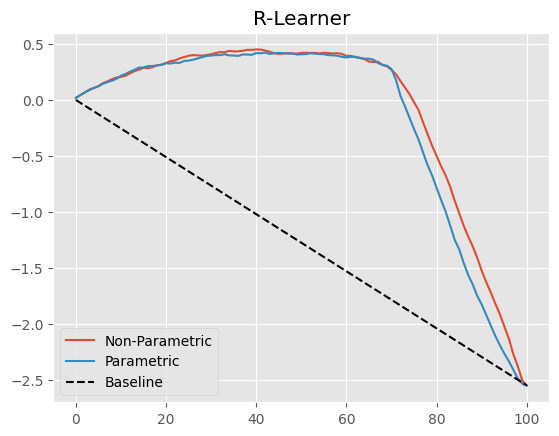

In [24]:
gain_curve_test_non_param = cumulative_gain(cate_test_non_param, "cate", y=y, t=T)
plt.plot(gain_curve_test_non_param, color="C0", label="Non-Parametric")
plt.plot(gain_curve_test, color="C1", label="Parametric")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("R-Learner");

Не такое уж большое улучшение, но всё же. К тому же, отсутствие необходимости указывать функциональную форму функции обработки — это уже огромное преимущество.

**Что такое непараметрический подход?**

Прежде чем мы продолжим, я хотел бы обратить внимание на распространённое заблуждение. При использовании непараметрической модели Double-ML для оценки CATE, похоже, мы получим нелинейный эффект воздействия. Например, предположим очень простой процесс генерации данных (DGP), где скидка влияет на продажи нелинейно, а через квадратный корень.

$
Sales_i = 20 + 10*\sqrt{Discount_i} + e_i
$

Эффект воздействия определяется производной этой функции продаж по воздействию.

$
\dfrac{\partial Sales_i}{\partial Discount_i} = \dfrac{10}{2\sqrt{Discount_i}}
$

Как мы видим, эффект воздействия **не** линейный. На самом деле он ослабевает по мере увеличения воздействия. Это имеет большое значение для данного DGP. Поначалу небольшая скидка значительно увеличивает продажи. Но по мере того, как мы предоставляем слишком большую скидку, дополнительная единица скидки будет влиять на продажи всё меньше и меньше, поскольку люди не захотят покупать бесконечно. Следовательно, скидка эффективна только до тех пор, пока они не пресытятся.

Возникает вопрос: может ли непараметрической ML уловить это насыщающее поведение в эффекте воздействия? Можно ли экстраполировать небольшой уровень скидки так, что при большей скидке эффект воздействия был бы ниже? Ответ - в некотором роде. Чтобы лучше понять это, давайте сгенерируем данные, как в приведенном выше DGP.

In [25]:
np.random.seed(321)
n=5000
discount = np.random.gamma(2,10, n).reshape(-1,1)
discount.sort(axis=0) # for better ploting
sales = np.random.normal(20+10*np.sqrt(discount), 1)

Если мы построим график DGP, то увидим нужную зависимость между этими переменными.

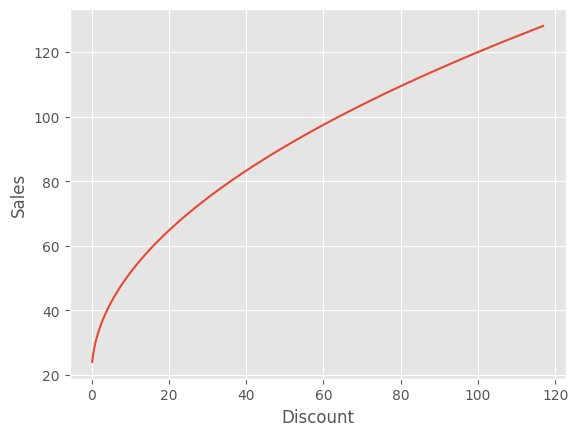

In [26]:
plt.plot(discount, 20 + 10*np.sqrt(discount))
plt.ylabel("Sales")
plt.xlabel("Discount");

Теперь применим к этим данным непараметрический метод Double/Debias ML.

In [27]:
debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

# orthogonalising step
discount_res =  discount.ravel() - cross_val_predict(debias_m, np.ones(discount.shape), discount.ravel(), cv=5)
sales_res =  sales.ravel() - cross_val_predict(denoise_m, np.ones(sales.shape), sales.ravel(), cv=5)

# final, non parametric causal model
non_param = LGBMRegressor(max_depth=3)
w = discount_res ** 2
y_star = sales_res / discount_res

non_param.fit(X=discount_res.reshape(-1,1), y=y_star.ravel(), sample_weight=w.ravel());

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 0
[LightGBM] [Info] Start training from score 23.675958
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


С помощью вышеприведённой модели мы можем получить оценку CATE. Проблема здесь в том, что CATE нелинейна. По мере увеличения воздействия CATE должна уменьшаться. Вопрос, который мы пытаемся решить, заключается в том, может ли непараметрическая модель учесть эту нелинейность.

Чтобы ответить на этот вопрос, давайте вспомним, какое основное предположение делает Double/Debiased ML относительно процесса генерации данных. Эти предположения можно увидеть в уравнении, которое мы привели ранее.

$
\tilde{Y}_i = \tau(X_i) \tilde{T}_i + e_i
$

Проще говоря, это означает, что остаточный результат равен остаточному результату воздействия, умноженному на условный эффект воздействия. Это означает, что **воздействие влияет на результат линейно**. Здесь нет нелинейности. Приведённая выше модель предполагает, что результат увеличится на фиксированную величину $\tau(X_i) $ при увеличении воздействия с 1 до 10 или со 100 до 110. Это простое умножение.

Означает ли это, что непараметрическая модель не может учесть нелинейность эффекта воздействия? Опять же, не совсем... Скорее, Double/ML **находит локально-линейное приближение к нелинейному CATE**. Другими словами, он находит производную результата по воздействию на данном уровне воздействия или вблизи него. Это эквивалентно нахождению наклонов прямых, касательных к функции результата в точке воздействия.

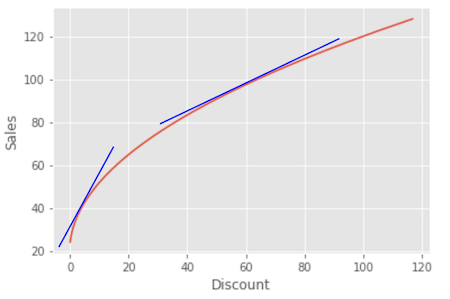

Это означает, что да, непараметрическая модель Double-ML определит, что эффект воздействия будет уменьшаться по мере увеличения воздействия. Но нет, он обнаружит не нелинейный эффект воздействия, а локальный линейный эффект. Мы даже можем построить графики этих линейных аппроксимаций относительно истинного нелинейного причинно-следственного эффекта, и они действительно являются хорошими аппроксимациями.

<>:12: SyntaxWarning: invalid escape sequence '\h'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\h'
<>:14: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-1491753946.py:12: SyntaxWarning: invalid escape sequence '\h'
  plt.scatter(discount, cate, label="$\hat{\\tau}(x)$", c="C4")
/tmp/ipython-input-1491753946.py:14: SyntaxWarning: invalid escape sequence '\p'
  plt.title("CATE ($\partial$Sales) by Discount")
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


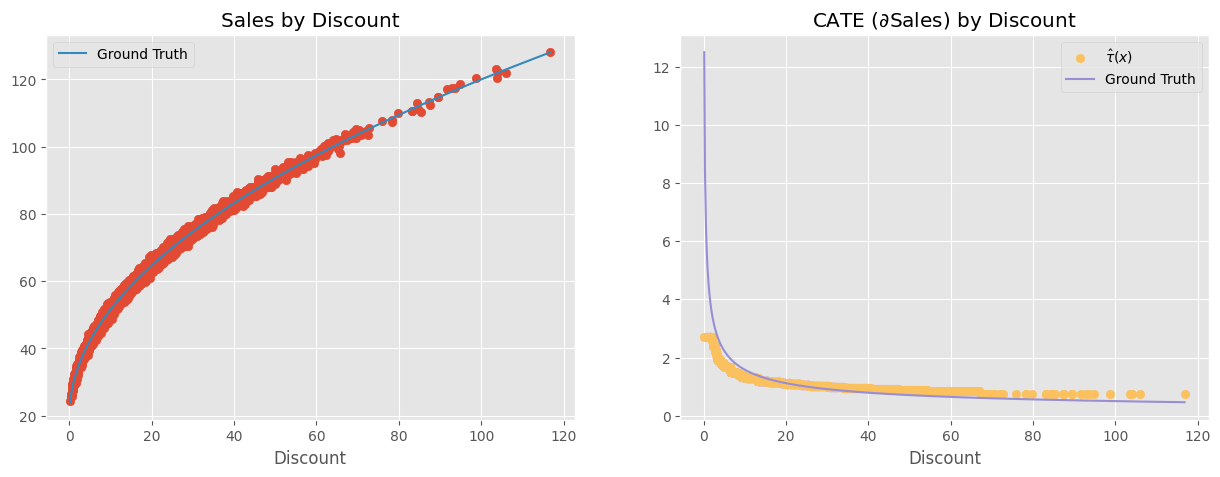

In [28]:
cate = non_param.predict(X=discount)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(discount, sales)
plt.plot(discount, 20 + 10*np.sqrt(discount), label="Ground Truth", c="C1")
plt.title("Sales by Discount")
plt.xlabel("Discount")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(discount, cate, label="$\hat{\\tau}(x)$", c="C4")
plt.plot(discount, 5/np.sqrt(discount), label="Ground Truth", c="C2")
plt.title("CATE ($\partial$Sales) by Discount")
plt.xlabel("Discount")
plt.legend();

Это может показаться формальностью, но имеет весьма практическое значение. Например, предположим, что для клиента из приведённого выше примера вы обнаружили эффект воздействия, равный 2, то есть при увеличении скидки на 1 единицу ваши продажи этому клиенту вырастут на 2 единицы. Вы можете подумать: «Отлично! Я дам много скидок на эту единицу! В конце концов, за каждую единицу скидки я получу 2 продажи». Однако это неверный вывод. Эффект воздействия равен 2 только при таком уровне скидки. Как только вы увеличите скидку, эффект снизится. Например, предположим, что этот гипотетический клиент получил скидку всего в 5 единиц, поэтому его эффект воздействия так высок. Допустим, вы видите этот огромный эффект воздействия и используете его, чтобы оправдать предоставление этому клиенту скидки в 20 единиц. Но по мере этого эффект может увеличиться с 2 до примерно 0,5. И скидка в 20 единиц, которая имела смысл при эффекте воздействия 2, может перестать быть прибыльной при эффекте воздействия 0,5.

Это означает, что необходимо быть особенно осторожным при экстраполяции нелинейного эффекта воздействия на новый уровень воздействия. В противном случае вы можете принять крайне невыгодные решения. Другими словами, если эффект воздействия нелинеен, даже непараметрический Double-ML будет **с трудом давать контрфактуальные прогнозы**. Он попытается линейно экстраполировать эффект воздействия с низкого уровня воздействия на высокий и наоборот. И из-за нелинейности эта экстраполяция, вероятно, будет неверной.

Чтобы решить эту проблему, есть последняя идея. Имейте в виду, что эта идея гораздо менее научна, чем то, что мы видели ранее. Давайте рассмотрим это далее.

**Ненаучное Double/Debiased ML**

Последняя идея, которую мы попробуем, — делать контрфактуальные прогнозы.

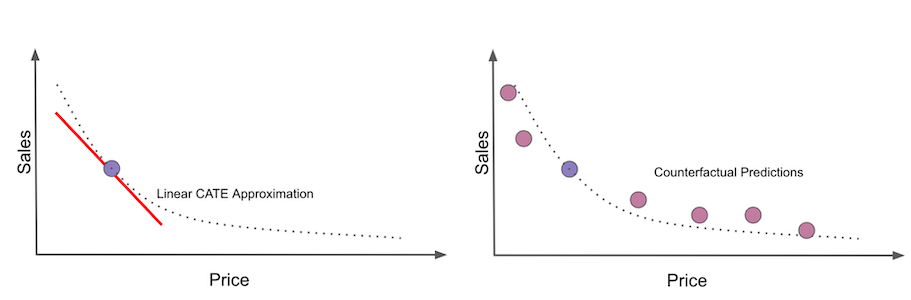

CATE — это наклон функции результата в точке данных. Он показывает, насколько, по нашим ожиданиям, изменится результат при небольшом увеличении воздействия. Более технически, это производная в этой точке. Контрфактуальные прогнозы, с другой стороны, — это попытка воссоздать всю кривую результата по одной точке данных. Мы предскажем, каким был бы результат, если бы воздействие проводилось на другом уровне, чем тот, который требуется в настоящее время, отсюда и контрфактуальность.

Если нам это удастся, мы сможем моделировать различные виды воздействия для одного объекта и предсказывать, как он будет реагировать на эти различные уровни. Это очень рискованное дело, поскольку мы будем экстраполировать всю кривую из одной точки.

Вот как это будет происходить. Сначала давайте начнём с традиционной формулы Double/Debiased ML, где у нас есть остаточная версия воздействия и результата.

$
\tilde{Y}_i = \tau(X_i) \tilde{T}_i + e_i
$

Теперь поместим воздействие внутрь функции эффекта. Это позволяет эффекту воздействия быть нелинейным, то есть меняться вместе с самим воздействием.

$
\tilde{Y}_i = \tau(X_i, \tilde{T}_i) + e_i
$

Это опасное дело, потому что мы понятия не имеем, как работает это воздействие. Насколько нам известно, это может быть какая-то странная нелинейная функция. Но, к счастью, мы знаем, как оценивать странные функции с помощью машинного обучения. Именно этим мы и займёмся. Проще говоря, мы подберём ML модель для прогнозирования остаточного результата $\tilde{Y}$ на основе остаточного воздействия $\tilde{T}$ и признаков $X$. Остаточное моделирование важно для устранения смещения и шума, чтобы итоговая модель могла сосредоточиться только на изучении эффекта воздействия и того, как ковариаты $X$ влияют на этот эффект.

Затем, получив эту модель, мы сделаем двухэтапные контрфактуальные прогнозы. Сначала нам нужно будет сделать прогноз для воздействия, чтобы получить $\tilde{T}$, а затем мы включим этот прогноз вместе с признаками в нашу финальную модель $\hat{\tau}(X_i, \tilde{T}_i)$.

Поскольку нам придётся создать $\tilde{T}$, сначала нужно реализовать собственную версию функции `cross_prediction`. Эта функция будет возвращать не только перекрёстное предсказание, но и модели, использованные для его создания.

In [29]:
from sklearn.model_selection import KFold

def cv_estimate(train_data, n_splits, model, model_params, X, y):
    cv = KFold(n_splits=n_splits)
    models = []
    cv_pred = pd.Series(np.nan, index=train_data.index)
    for train, test in cv.split(train_data):
        m = model(**model_params)
        m.fit(train_data[X].iloc[train], train_data[y].iloc[train])
        cv_pred.iloc[test] = m.predict(train_data[X].iloc[test])
        models += [m]

    return cv_pred, models


Теперь, когда у нас есть собственная функция перекрестного прогнозирования, которая также дает нам модели, мы можем приступить к этапу ортогонализации.

In [30]:
y = "sales"
T = "price"
X = ["temp", "weekday", "cost"]

debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

y_hat, models_y = cv_estimate(train, 5, LGBMRegressor, dict(max_depth=3), X, y)
t_hat, models_t = cv_estimate(train, 5, LGBMRegressor, dict(max_depth=3), X, T)

y_res = train[y] - y_hat
t_res = train[T] - t_hat

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 3
[LightGBM] [Info] Start training from score 200.473000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

После ортогонализации мы передадим $\tilde{T}$ вместе с $X$ в модель машинного обучения, которая попытается предсказать $\tilde{Y}$. Используем модель LGBM, но вы можете выбрать любую модель машинного обучения. Преимущество LGBM заключается в том, что можно задать для неё монотонные ограничения. Зная то, что нам известно о ценах, мы можем предположить, что продажи должны снижаться с ростом цен. Мы можем учесть это и ограничить нашу модель LGBM так, чтобы она **не увеличивала** свои прогнозы при росте цен.

In [31]:
# -1 on price saying that the predictions should not increase as price increases
monotone_constraints = [-1 if col == T else 0 for col in X+[T]]

model_final = LGBMRegressor(max_depth=3, monotone_constraints=monotone_constraints)
model_final = model_final.fit(X=train[X].assign(**{T: t_res}), y=y_res)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 494
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 4
[LightGBM] [Info] Start training from score 0.010779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

А вот теперь всё становится немного странным. Если задуматься, эта финальная модель оценивает следующую функцию воздействия $\tau$:

$
\tilde{Y}_i = \tau(X_i, \tilde{T}_i) + e_i
$

но нет чёткого способа извлечь эффект воздействия из этой функции. Поэтому вместо того, чтобы извлекать эффект воздействия, мы введём контрфактуальные прогнозы, как я показал на предыдущем рисунке. Мы смоделируем разные уровни цен для каждой единицы товара и используем модель, чтобы предсказать, какой объём продаж мы увидим при этих разных уровнях цен.

Для этого мы соединим тестовый набор с таблицей цен, содержащей все смоделированные цены. Конечный результат будет следующим:

In [32]:
pred_test = (test
             .rename(columns={"price":"factual_price"})
             .assign(jk = 1)
             .reset_index() # create day ID
             .merge(pd.DataFrame(dict(jk=1, price=np.linspace(3, 10, 9))), on="jk")
             .drop(columns=["jk"]))

pred_test.query("index==0")

,index,temp,weekday,cost,factual_price,sales,price
0,0,25.8,1,0.3,7,230,3.000
1,0,25.8,1,0.3,7,230,3.875
2,0,25.8,1,0.3,7,230,4.750
3,0,25.8,1,0.3,7,230,5.625
4,0,25.8,1,0.3,7,230,6.500
5,0,25.8,1,0.3,7,230,7.375
6,0,25.8,1,0.3,7,230,8.250
7,0,25.8,1,0.3,7,230,9.125
8,0,25.8,1,0.3,7,230,10.000


Notice that we are showing only the day in index 1, so only a single unit. On that day (unit), the actual or factual price or treatment was 7. But we've simulated different counterfactual treatments, from 3 to 10. Now, we will feed all those counterfactual prices to our causal model, which will make counterfactual sales predictions based on those simulated prices.

Since our model has the following format

$
\widehat{Price_i} = \hat{\tau}(X_i, \tilde{T}_i)
$

Before making the counterfactual predictions, we need to get $\tilde{T}_i$, that is, the price residuals. We will get those residuals by first, making predictions will all our treatment models (remember that we've used a 5 fold cross prediction in the training step), then we will average the predictions from the five models into a single prediction and finally subtract the counterfactual price we've generated earlier from the predicted price using this ensemble of models.

Обратите внимание, что мы показываем только день в индексе 1, то есть только одну единицу. В этот день (единицу) фактическая цена или мера воздействия составляла 7. Но мы смоделировали различные варианты воздействия, от 3 до 10. Теперь мы введем все эти контрфактуальные цены в нашу причинно-следственную модель, которая будет делать контрфактуальные прогнозы продаж на основе этих смоделированных цен.

Поскольку наша модель имеет следующий формат:

$
\widehat{Price_i} = \hat{\tau}(X_i, \tilde{T}_i)
$

Прежде чем делать контрфактуальные прогнозы, нам нужно получить $\tilde{T}_i$, то есть остатки цен. Сначала мы получим эти остатки, сделав прогнозы с использованием всех наших моделей воздействия (помните, что на этапе обучения мы использовали 5-кратное перекрестное прогнозирование), затем мы усредним прогнозы из пяти моделей в один прогноз и, наконец, вычтем контрфактическую цену, которую мы сгенерировали ранее, из прогнозируемой цены с использованием этого ансамбля моделей.

In [33]:
def ensamble_pred(df, models, X):
    return np.mean([m.predict(df[X]) for m in models], axis=0)

t_res_test = pred_test[T] - ensamble_pred(pred_test, models_t, X)

pred_test[f"{y}_pred"] = model_final.predict(X=pred_test[X].assign(**{T: t_res_test}))

pred_test.query("index==0")

,index,temp,weekday,cost,factual_price,sales,price,sales_pred
0,0,25.8,1,0.3,7,230,3.000,24.302849
1,0,25.8,1,0.3,7,230,3.875,20.862833
2,0,25.8,1,0.3,7,230,4.750,16.093630
3,0,25.8,1,0.3,7,230,5.625,6.274595
4,0,25.8,1,0.3,7,230,6.500,-1.624625
5,0,25.8,1,0.3,7,230,7.375,-10.939867
6,0,25.8,1,0.3,7,230,8.250,-21.655858
7,0,25.8,1,0.3,7,230,9.125,-25.319174
8,0,25.8,1,0.3,7,230,10.000,-25.319174


Как видите, теперь у нас есть прогноз продаж для каждой смоделированной цены. Чем ниже цена, тем выше продажи. Интересно, что эти прогнозы не соответствуют действительности. Например, они колеблются от примерно 24 до примерно -24. Это связано с тем, что модель предсказывает остаточный результат, который примерно равен нулю. Этого достаточно, если вам нужно всего лишь получить наклон кривой продаж, который отражает эффект воздействия цены. Кроме того, если вы хотите исправить уровни прогнозов, вам нужно просто добавить прогнозы из модели шумоподавления $M_y$.

In [34]:
y_hat_test = ensamble_pred(pred_test, models_y, X)
pred_test[f"{y}_pred"] = (y_hat_test +
                          model_final.predict(X=pred_test[X].assign(**{T: t_res_test})))

pred_test.query("index==0")

,index,temp,weekday,cost,factual_price,sales,price,sales_pred
0,0,25.8,1,0.3,7,230,3.000,254.208352
1,0,25.8,1,0.3,7,230,3.875,250.768336
2,0,25.8,1,0.3,7,230,4.750,245.999133
3,0,25.8,1,0.3,7,230,5.625,236.180099
4,0,25.8,1,0.3,7,230,6.500,228.280878
5,0,25.8,1,0.3,7,230,7.375,218.965636
6,0,25.8,1,0.3,7,230,8.250,208.249645
7,0,25.8,1,0.3,7,230,9.125,204.586329
8,0,25.8,1,0.3,7,230,10.000,204.586329


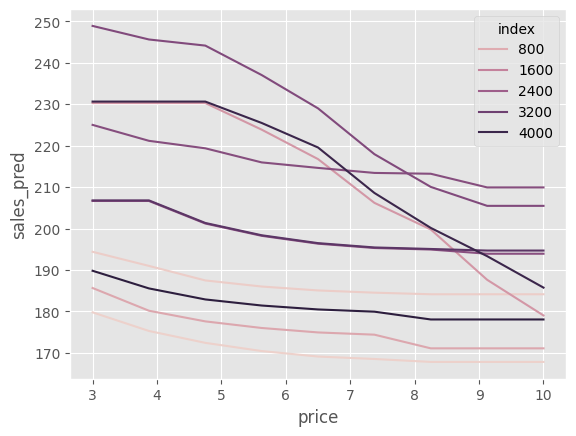

In [35]:
np.random.seed(1)
sample_ids = np.random.choice(pred_test["index"].unique(), 10)

sns.lineplot(data=pred_test.query("index in @sample_ids"),
             x="price", y="sales_pred", hue="index");

Интересно отметить, что некоторые товары очень чувствительны к повышению цены. В некоторых случаях мы ожидаем падения продаж с 250 до почти 200 при повышении цены с 3 до 10. С другой стороны, некоторые товары очень неэластичны к цене: при повышении цены с 3 до 10 мы ожидаем, что продажи упадут примерно со 195 до 185.

Эти различия в чувствительности к цене сложно увидеть, поэтому я предпочитаю начинать все кривые с одной и той же точки (здесь — средний уровень продаж). Это позволит лучше увидеть, что у некоторых товаров продажи резко падают при повышении цены, а у других — не так сильно.

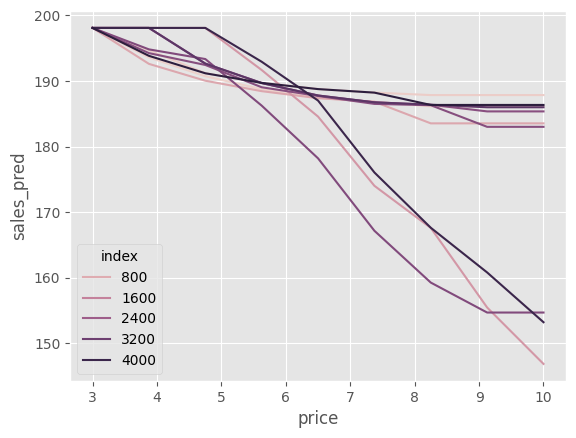

In [36]:
np.random.seed(1)
sample_ids = np.random.choice(pred_test["index"].unique(), 10)

sns.lineplot(data=(pred_test
                   .query("index in @sample_ids")
                   .assign(max_sales = lambda d: d.groupby("index")[["sales_pred"]].transform("max"))
                   .assign(sales_pred = lambda d: d["sales_pred"] - d["max_sales"] + d["sales_pred"].mean())),
             x="price", y="sales_pred", hue="index");

**Может потребоваться больше эконометрики**

Я хочу завершить этот раздел, посвящённый ненаучному Double-ML, предостережением. Я не зря назвал этот подход ненаучным. Это своего рода хак для получения нелинейных контрфактуальных прогнозов. И поскольку это хак, я считаю, что стоит поговорить о его потенциальных недостатках.

Прежде всего, у него есть те же проблемы, что и у всех методов ML при наивном применении к причинно-следственной связи: смещение. Поскольку итоговая модель — это регуляризованная ML модель, эта регуляризация может сместить оценку причинно-следственной связи до нуля.

Вторая проблема связана с выбранным ML алгоритмом. Здесь мы используем бустинг. Деревья не очень хорошо справляются с гладкими прогнозами. Как следствие, на кривой прогнозирования могут быть разрывы. Вы можете видеть это на графиках выше: ступенчатое поведение здесь и там. Кроме того, деревья не очень хорошо справляются с экстраполяцией, поэтому эта модель может выдавать странные прогнозы относительно цен, которых никогда не наблюдалось ранее.

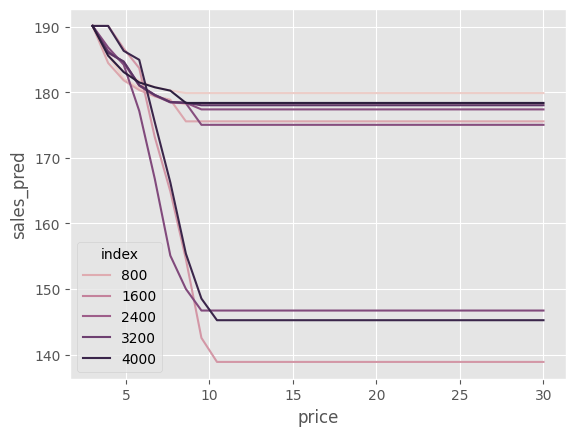

In [37]:
pred_test = (test
             .rename(columns={"price":"factual_price"})
             .assign(jk = 1)
             .reset_index() # create day ID
             .merge(pd.DataFrame(dict(jk=1, price=np.linspace(3, 30, 30))), on="jk")
             .drop(columns=["jk"]))

t_res_test = pred_test[T] - ensamble_pred(pred_test, models_t, X)

y_hat_test = ensamble_pred(pred_test, models_y, X)
pred_test[f"{y}_pred"] = model_final.predict(X=pred_test[X].assign(**{T: t_res_test})) + y_hat_test

np.random.seed(1)
sample_ids = np.random.choice(pred_test["index"].unique(), 10)

sns.lineplot(data=(pred_test
                   .query("index in @sample_ids")
                   .assign(max_sales = lambda d: d.groupby("index")[["sales_pred"]].transform("max"))
                   .assign(sales_pred = lambda d: d["sales_pred"] - d["max_sales"] + d["sales_pred"].mean())),
             x="price", y="sales_pred", hue="index");

Всё это говорит о том, что этот подход сильно зависит от финальной модели. Если вы слишком сильно её регуляризуете, ваши оценки причинно-следственных связей сведутся к нулю. Использование того или иного алгоритма переносит все его ограничения на ваши финальные контрфактуальные прогнозы. Тем не менее, если вы считаете, что этот подход стоит попробовать, обязательно попробуйте! Только не забывайте о недостатках, которые я здесь описал.

#### Casual Impact

**Введение и Постановка Проблемы**

Определение причинно-следственного влияния рыночных интервенций — это **важная и актуальная задача** в эконометрике и маркетинге. Многие компании осознали, что систематическое использование метрик влияния для принятия стратегических решений может дать им конкурентное преимущество. Примером является использование "A/B экспериментов" для выявления наиболее эффективных рыночных воздействий с целью распределения ресурсов.

Однако существуют ситуации, когда **рандомизированный эксперимент невозможен**. Например, рекламные кампании часто запускаются по множеству каналов (онлайн и офлайн), что исключает измерение индивидуального воздействия. Кампании могут быть нацелены на целую страну, что запрещает использование географических контролей внутри этой страны. В таких случаях традиционные подходы, такие как разность разностей (difference-in-differences, DD), имеют **ограничения**.

Метод, предложенный в статье, **CausalImpact**, направлен на решение этой проблемы. Он позволяет **выводить причинно-следственное влияние** рыночной интервенции, такой как запуск нового продукта или начало рекламной кампании, на основе диффузионно-регрессионной модели пространства состояний.

**Ключевые преимущества подхода CausalImpact**:
*   **Оценка временной эволюции влияния**: В отличие от классических схем разности разностей, модели пространства состояний позволяют **выводить временную эволюцию приписываемого воздействия**.
*   **Байесовский подход**: Метод включает **эмпирические априорные распределения** для параметров в **полностью байесовской обработке**, а также использует **байесовское усреднение моделей** для построения наиболее подходящего синтетического контроля.
*   **Гибкость**: Он гибко учитывает **множественные источники вариации**, включая локальные тренды, сезонность и изменяющееся во времени влияние современных ковариат.

**Байесовские Структурные Временные Ряды (BSTS)**

Метод CausalImpact основан на **байесовских структурных моделях временных рядов (Bayesian Structural Time Series, BSTS)**, которые являются частным случаем моделей пространства состояний. Эти модели отличаются тем, что они могут гибко адаптироваться к различным предположениям о скрытом состоянии и процессах эмиссии, лежащих в основе наблюдаемых данных.

**Общая форма моделей пространства состояний** определяется парой уравнений:

1.  **Уравнение наблюдений (Observation Equation)**: Связывает наблюдаемые данные с латентным вектором состояния.
$
y_t = Z_t^{T}\alpha_t + \epsilon_{t}
$
2.  **Уравнение состояния (State Equation)**: Описывает эволюцию вектора состояния во времени.
$
\alpha_{t+1} = T_{t}\alpha_t + R_t \eta_t
$

Где:
*   $y_t$ — скалярное наблюдение в момент времени $t$ (например, продажи или посещения сайта).
*   $\alpha_t$ — $d$-мерный латентный вектор состояния в момент времени $t$.
*   $Z_t$ — $d$-мерный выходной вектор.
*   $T_t$ — $d × d$ матрица перехода, описывающая, как состояние $\alpha_t$ эволюционирует к $\alpha_{t+1}$.
*   $R_t$ — $d × q$ контрольная матрица.
*   $\epsilon_{t}$ — скалярная ошибка наблюдения, предполагаемая как $\epsilon_{t} ∼ N(0, σ^2_t)$, независимая от других неизвестных.
*   $η_t$ — $q$-мерная системная ошибка, предполагаемая как $η_t ∼ N(0, Q_t)$, независимая от других неизвестных.
*   $Q_t$ — $q × q$ матрица диффузии состояния.

Структурные модели временных рядов очень **гибкие и модульные**. Они гибкие в том смысле, что очень широкий класс моделей, включая все модели ARIMA, может быть записан в форме пространства состояний. Они модульные в том смысле, что латентное состояние, а также связанные с ним матрицы $Z_t, T_t, R_t$ и $Qt$ могут быть собраны из **компонентных подмоделей** для захвата важных особенностей данных. Обычно предполагается, что ошибки различных компонентных моделей состояния независимы, что позволяет формировать $\alpha_t$ путем конкатенации индивидуальных компонент состояния, а $T_t$ и $R_t$ становятся блочно-диагональными матрицами.

\\

**Компоненты состояния**:
Модель CausalImpact может включать следующие компоненты состояния:

*   **Локальный линейный тренд (Local linear trend)**:

  Эта компонента моделирует изменяющийся во времени уровень ($μ_t$) и его ожидаемое изменение (наклон $δ_t$).

  $μ_{t+1} = μ_t + δ_t + η_{μ,t}$

  $δ_{t+1} = δ_t + η_{δ,t}$
  
  где $η_{μ,t} ∼ N(0, σ^2_μ)$ и $η_{δ,t} ∼ N(0, σ^2_δ)$ — независимые ошибки.
  Это популярный выбор для моделирования трендов, так как он **быстро адаптируется к локальным вариациям**, что желательно для краткосрочных прогнозов. Существует также обобщение этой модели, где наклон демонстрирует стационарность вместо случайного блуждания, балансируя краткосрочную информацию с информацией из далекого прошлого.

*   **Сезонность (Seasonality)**:
  
  Эта компонента учитывает регулярные сезонные колебания в данных. Наиболее часто используемая модель в временной области:

  $γ_{t+1} =  - \displaystyle\sum_{s=0}^{S-2} γ_{t-s} + η_{γ,t}$

  где $S$ — количество сезонов (например, $S=7$ для дневного эффекта недели), а $γ_t$ обозначает их совместный вклад в наблюдаемый отклик $y_t$. Среднее значение $γ_{t+1}$ таково, что общий сезонный эффект равен нулю при суммировании за $S$ сезонов. Эта модель может быть обобщена для нескольких сезонных компонент с различными периодами.

*   **Современные ковариаты со статическими коэффициентами (Contemporaneous covariates with static coefficients)**:
  
  Контрольные временные ряды, которые не подвергались воздействию, **критически важны для получения точных контрфактических прогнозов**, поскольку они объясняют компоненты дисперсии, общие для ряда, включая эффекты других ненаблюдаемых причин. Линейная регрессия является естественным способом включения контрольных рядов в модель. В статической регрессии коэффициенты $β$ остаются постоянными. В байесовском подходе **нет необходимости фиксировать набор ковариат**, благодаря использованию **spike-and-slab априорного распределения**. Оно позволяет интегрировать апостериорную неопределенность относительно того, какие ковариаты включать и как сильно они должны влиять на прогнозы, что **помогает избежать переобучения**.

*   **Современные ковариаты с динамическими коэффициентами (Contemporaneous covariates with dynamic coefficients)**:
  
  Альтернативой статическим коэффициентам является регрессионная компонента с **динамическими коэффициентами регрессии** для учета изменяющихся во времени связей.
  
  $x^T_t β_t = \displaystyle \sum_{j=1}^J x_{j,t}β_{j,t}$

  $β_{j,t+1} = β_{j,t} + η_{β,j,t}$
  
  где $βj,t$ — коэффициент для $j$-го контрольного ряда, а $η_{β,j,t} ∼ N(0, σ^2_{βj})$ — ошибка случайного блуждания.
  
  Динамические коэффициенты полезны, когда предполагается, что **линейная связь между обрабатываемыми метриками и контролями меняется со временем**.


Структурные модели временных рядов позволяют гибко выбирать подходящие компоненты для тренда, сезонности и регрессии (статической или динамической). Например, наличие или отсутствие сезонности обычно очевидно при визуальном осмотре. Статические коэффициенты привлекательны, когда связь между контролями и обрабатываемой единицей была стабильной в прошлом, так как spike-and-slab априорное распределение может быть эффективно реализовано. Динамические коэффициенты используются, когда эта связь, как считается, меняется со временем.


На рисунке ниже представлена графическая модель для варианта модели пространства состояний со статической регрессией.
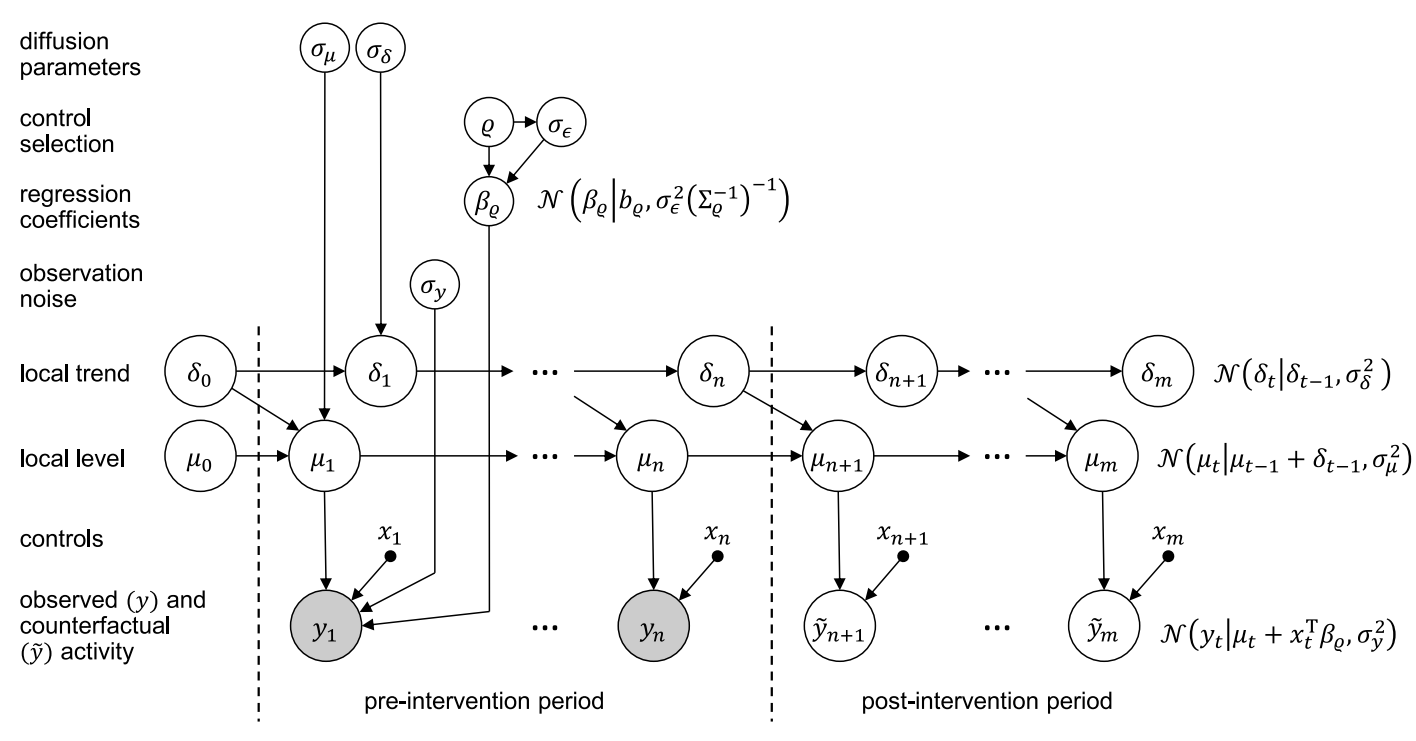

**Принцип работы метода CausalImpact**

Метод CausalImpact inferring причинно-следственное воздействие на основе диффузионно-регрессионной модели пространства состояний, которая **прогнозирует контрфактический отклик**, который произошел бы, если бы не было вмешательства. Он использует три основных шага: построение контрфактической модели, прогнозирование контрфактического сценария и оценку причинно-следственного эффекта.

**Источники информации для построения синтетического контроля**:
1.  **Поведение временного ряда самого отклика** до интервенции.
2.  **Поведение других временных рядов**, которые были предсказуемы для целевого ряда до интервенции (контрольные ряды).
3.  **Априорные знания** о параметрах модели в байесовской структуре.

Эти три источника информации объединяются с использованием модели временных рядов в пространстве состояний.

**Шаг 1: Построение контрфактической модели**

Этот шаг включает в себя **определение и обучение модели BSTS** на данных, предшествующих интервенции (тренировочный период), чтобы она могла точно предсказывать поведение целевого временного ряда $y_t$ в отсутствие вмешательства.

1.  **Выбор компонент состояния**

  Как обсуждалось выше, модель может включать компоненты для **тренда**, **сезонности** и **регрессии на современных ковариатах**. Выбор зависит от характеристик данных и предметной области.
    *   Например, для анализа рекламной кампании в статье использовалась комбинация **локального уровня** и **статической регрессионной компоненты**.
    *   При анализе симулированных данных использовалась **динамическая регрессионная компонента**.

2.  **Спецификация априорных распределений (Prior distributions)**:
    
  В байесовском подходе мы задаем априорные распределения $p(θ)$ для всех параметров модели $θ$ и $p(α_0|θ)$ для начальных значений состояния $α0$.

    *   **Для дисперсионных параметров**
    
      Типичное априорное распределение для дисперсии ($σ^2$) — это **обратное гамма-распределение** $\frac{1}{σ^2} ∼ G(\frac{ν}{2}, \frac{s}{2})$
    
      где $G(a, b)$ — гамма-распределение с ожиданием $a/b$. Параметры $ν$ и $s$ можно интерпретировать как априорную сумму квадратов и вес в единицах размера априорной выборки. Часто используются слабые, неинформативные априорные распределения (например, $ν=1$, $s/ν$ — малое значение).

    *   **Для коэффициентов регрессии (Spike-and-Slab prior)**
    
      Когда имеется много потенциальных ковариат (контрольных рядов $x_t$), модель сама выбирает наиболее подходящий набор с помощью **spike-and-slab априорного распределения**. Это распределение сочетает точечную массу в нуле (the "spike") для неизвестного подмножества нулевых коэффициентов с слабо информативным распределением на дополнительном наборе ненулевых коэффициентов (the "slab").
        Пусть $γ = (γ_1, ..., γ_J)$, где $γ_j = 1$, если $β_j ≠ 0$, и $γ_j = 0$ в противном случае. Пусть $β_γ$ обозначает ненулевые элементы вектора $β$.
        Априорное распределение факторизуется как:

        $p(γ, β, 1/σ^2_{ε}) = p(γ) p(σ^2_ε | γ) p(β_γ | γ,σ^2_ε)$

        *   **"Spike" (выбор переменных)**: Часто используется произведение независимых распределений Бернулли:

        $p(γ) = \displaystyle\prod_{j=1}^J π_j^{γ_j} (1 - π_j)^{1-γ_j}$

        где $π_j$ — априорная вероятность включения регрессора $j$ в модель. Значения $π_j$ можно определить, задав ожидаемый размер модели $M$ (например, $π_j = M/J$).

        *   **"Slab" (распределение ненулевых коэффициентов)**: Используется сопряженное нормальное-обратное гамма-распределение:
        
        $β_γ | σ^2_ε ∼ N(b_γ, σ^2_ε (\sum^{-1}_γ)^{-1})$

        $\frac{1}{σ^2_ε} ∼ G(ν_ε/2, s_ε/2)$

        Вектор $b_γ$ кодирует априорное ожидание значения каждого элемента $β$ (часто $b_γ = 0$). Параметры $ν_ε$ и $s_ε$ определяются ожидаемым $R^2$ и количеством наблюдений, которым присваивается вес.

3.  **Апостериорный вывод (Posterior Inference)**

  Поскольку замкнутых форм для апостериорных распределений не существует, для вывода используется **алгоритм Монте-Карло по Марковским цепям (MCMC)**, в частности, **сэмплер Гиббса**.
    *   **Шаг увеличения данных (Data-augmentation step)**: симулирует $p(α|y_{1:n}, θ)$ (последовательность состояний $α$ при заданных данных и параметрах) с использованием алгоритма симуляции сглаживателя от Дурбина и Купмана (2002). Этот алгоритм является линейным по количеству временных точек и квадратичным по размерности пространства состояний.
    *   **Шаг симуляции параметров (Parameter-simulation step)**: симулирует $p(θ|y_{1:n}, α)$ (параметры $θ$ при заданных данных и состояниях). Для большинства компонент это просто благодаря сопряженности априорных распределений. Для статических коэффициентов регрессии $β$ симуляция включает выбор $γ$ из $p(γ|y_{1:n})$ с последующим семплированием $β$ и $σ^2_ε$ из сопряженных формул.

**Шаг 2: Прогнозирование контрфактического сценария**

После обучения модели на пред-интервенционных данных и получения апостериорных выборок параметров ($θ$) и состояний ($α$), следующим шагом является **прогнозирование контрфактического временного ряда**. Контрфактический сценарий — это **ненаблюдаемый рыночный отклик $ỹ_{n+1:m}$**, который произошел бы на обработанном рынке после интервенции в отсутствие воздействия.

1.  **Апостериорное предиктивное распределение**

  Прогнозирование осуществляется путем симуляции из **апостериорного предиктивного распределения**:
  $p(ỹ_{n+1:m} | y_{1:n}, x_{1:m})$

  Это распределение определяется для той части временного ряда, которая является ненаблюдаемой, то есть для контрфактических откликов $ỹ_{n+1}, ..., ỹ_m$.
  **Важно**: Плотность обусловлена только наблюдаемыми данными (до интервенции для целевого ряда $y_{1:n}$) и активностью во всех контрольных рынках (как до, так и во время интервенции $x_{1:m}).

2.  **Байесовское усреднение моделей (Bayesian Model Averaging)**

   Модель **не фиксируется на каком-либо конкретном наборе ковариат** или точечных оценках их коэффициентов. Вместо этого, благодаря байесовскому усреднению моделей, **неопределенность относительно выбора ковариат и их влияния интегрируется**. Это помогает избежать произвольного выбора и переобучения.
3.  **Когерентность прогнозов**

  Апостериорная предиктивная плотность определяется как **когерентное (совместное) распределение** по всем контрфактическим точкам данных, а не как набор поточечных одномерных распределений. Это гарантирует, что сериальная структура, определенная на данных до интервенции, правильно распространяется на траекторию контрфактов. Это крайне важно при формировании сводных статистик, таких как **кумулятивный эффект**.


**Шаг 3: Оценка каузального эффекта**

Имея выборки из апостериорного предиктивного распределения контрфактической активности, можно легко получить выборки **причинно-следственного эффекта**.

1.  **Поточечное влияние (Pointwise impact)**
  
  Для каждой выборки $τ$ и для каждого момента времени $t = n+1, ..., m$ (период после интервенции) поточечное влияние $φ^{(τ)}_t$ определяется как разность между наблюдаемым значением $y_t$ и предсказанным контрфактическим значением $ỹ^{(τ)}_t$: $φ^{(τ)}_t := y_t - ỹ^{(τ)}_t$
    
  Это дает выборки из приближенной апостериорной предиктивной плотности эффекта, приписываемого интервенции.

2.  **Кумулятивное влияние (Cumulative impact)**

  Часто желательно понять **кумулятивный эффект** интервенции с течением времени. С использованием полученных выборок влияния $φ^{(τ)}_t$ можно вычислить кумулятивную сумму для каждой выборки $τ$:

  $\displaystyle\sum_{(t'=n+1)}^t φ^{(τ)}_{t'} \qquad ∀t = n+1, ..., m$
  
  Эта кумулятивная сумма полезна, когда $y$ представляет собой **потоковую величину**.

3.  **Среднее влияние (Running average impact)**

  Если $y$ представляет **запасовую величину** (например, общее количество клиентов), кумулятивная сумма может быть неинтерпретируемой. В этом случае можно рассчитать среднее влияние:
  $\frac{1}{t - n} \displaystyle \sum_{t'=n+1}^t φ^{(τ)}_{t'}  \qquad   ∀t = n+1, ..., m$
  
  Среднее влияние всегда интерпретируемо, но более зависимо от длины постинтервенционного периода.


Таким образом, CausalImpact предоставляет **мощный и гибкий байесовский фреймворк** для оценки причинно-следственного влияния в условиях, когда рандомизированные эксперименты невозможны или непрактичны, используя структурные модели временных рядов и продвинутые байесовские методы для построения синтетических контролей и вывода апостериорных распределений для эффекта.

In [40]:
!pip install -q pycausalimpact
import pandas as pd
from causalimpact import CausalImpact
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1)

df = pd.read_excel('amt_key.xlsx')
df.columns = ['date', 'cred_amt', 'key_value_perc']
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.head(3)

,cred_amt,key_value_perc
date,,
2013-09-30,720230,0.055
2013-10-31,776353,0.055
2013-11-30,736822,0.055


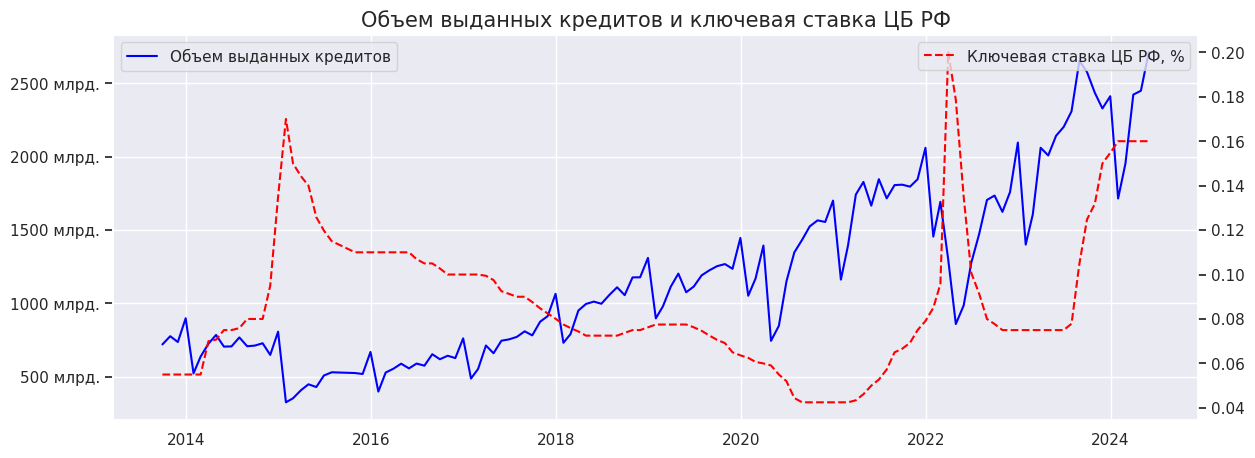

In [41]:
import warnings as w
w.filterwarnings('ignore')

fig, ax1 = plt.subplots(figsize=(14, 5))
ax2 = ax1.twinx()

ax1.plot(df['cred_amt'], color='blue', label='Объем выданных кредитов, млн. руб.');
ax2.plot(df['key_value_perc'], color='red', label='Ключевая ставка ЦБ РФ, %', ls='--');
ax1.legend(['Объем выданных кредитов']);
ax1.set_yticklabels(['{:.0f} млрд.'.format(x*1000000/1000000000) for x in ax1.get_yticks()])
ax2.legend(['Ключевая ставка ЦБ РФ, %'], loc='upper right');
ax2.grid(False)
plt.title('Объем выданных кредитов и ключевая ставка ЦБ РФ', fontsize=15);

Теперь определим период для оценки влияния ключевой ставки на объем выданных кредитов. Для примера возьмем ситуацию в марте 2022 года, когда ЦБ РФ резко поднял ключевую ставку с 9,58% до 20,00% и оценим, насколько уменьшился объем выданных кредитов относительно ситуации, если бы ЦБ РФ не поднимал ставку.

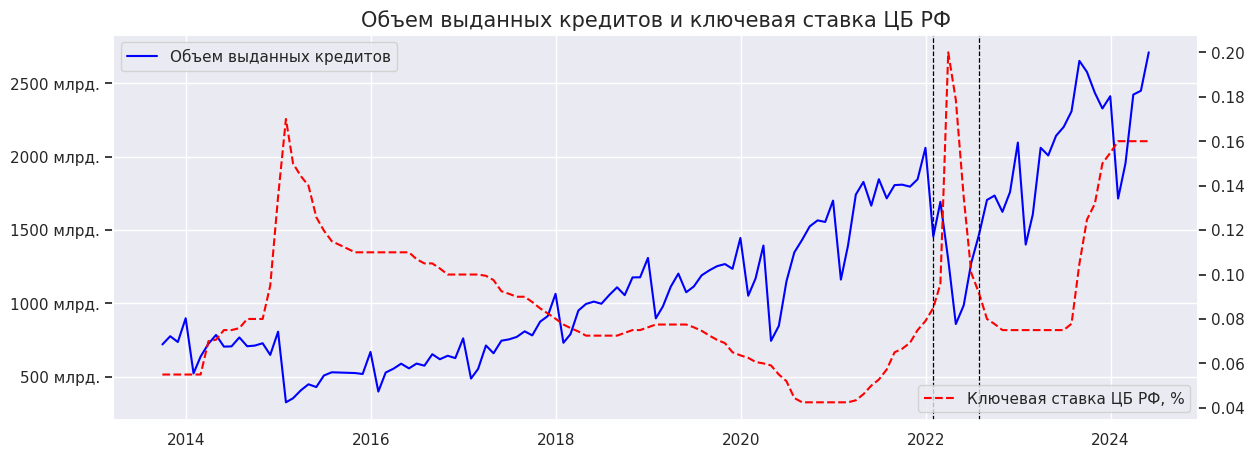

In [42]:
import warnings as w
w.filterwarnings('ignore')

fig, ax1 = plt.subplots(figsize=(14, 5))
ax2 = ax1.twinx()

ax1.plot(df['cred_amt'], color='blue', label='Объем выданных кредитов, млн. руб.');
ax2.plot(df['key_value_perc'], color='red', label='Ключевая ставка ЦБ РФ, %', ls='--');
ax1.legend(['Объем выданных кредитов']);
ax1.set_yticklabels(['{:.0f} млрд.'.format(x*1000000/1000000000) for x in ax1.get_yticks()])
ax2.legend(['Ключевая ставка ЦБ РФ, %'], loc='lower right');
ax2.grid(False)
plt.title('Объем выданных кредитов и ключевая ставка ЦБ РФ', fontsize=15);
plt.axvline(pd.to_datetime('2022-01-31'), color='black', ls='--', lw=0.9);
plt.axvline(pd.to_datetime('2022-07-31'), color='black', ls='--', lw=0.9);

Для предсказания Causal Impact использует Линейную регрессию и для нее, как и для любой модели, действует правило – чем больше данных, тем лучше прогноз. Поэтому создадим дополнительные предикторы (признаки) для нашей модели на основе тех данных, которые у нас есть. Для этого я создал функцию create_features.

In [43]:
def create_features(df_in, lags=3, target='cred_amt'):
    tmp = df_in.copy()
    tmp['day'] = tmp.index.day
    tmp['year'] = tmp.index.year
    tmp['month'] = tmp.index.month
    tmp['month_to_new_year'] = 12 - tmp.index.month

    tmp['rolling_mean_{}'.format(lags)] = tmp[target].rolling(lags, closed='left').mean()
    for lag in range(1, lags+1):
        tmp['lag_{}'.format(lag)] = tmp[target].shift(lag)

    return tmp

train_data = create_features(df).dropna()
train_data.head()

,cred_amt,key_value_perc,day,year,month,month_to_new_year,rolling_mean_3,lag_1,lag_2,lag_3
date,,,,,,,,,,
2013-12-31,898756,0.055000,31,2013,12,0,744468.333333,736822.0,776353.0,720230.0
2014-01-31,523223,0.055000,31,2014,1,11,803977.000000,898756.0,736822.0,776353.0
2014-02-28,637611,0.055000,28,2014,2,10,719600.333333,523223.0,898756.0,736822.0
2014-03-31,725301,0.070000,31,2014,3,9,686530.000000,637611.0,523223.0,898756.0
2014-04-30,784935,0.070682,30,2014,4,8,628711.666667,725301.0,637611.0,523223.0


Также для точности добавим такой показатель как количество населения России. Ведь население росло, а от этого и рос объем выданных кредитов. Данные о количестве населения я взял из Росстата (https://rosstat.gov.ru/storage/mediabank/Popul_1897+.xlsx).

In [45]:
pop = pd.read_excel('rf_population.xlsx')

train_index = train_data.index
train_data = train_data.merge(pop, left_on='year', right_on='date')
train_data.index = train_index

train_data.head()

,cred_amt,key_value_perc,day,year,month,month_to_new_year,rolling_mean_3,lag_1,lag_2,lag_3,...,city_population_x,village_population_x,city_pop_perc_x,village_pop_perc_x,date_y,population_y,city_population_y,village_population_y,city_pop_perc_y,village_pop_perc_y
date,,,,,,,,,,,,,,,,,,,,,
2013-12-31,898756,0.055000,31,2013,12,0,744468.333333,736822.0,776353.0,720230.0,...,106.4,37.2,74,26,2013,143.6,106.4,37.2,74,26
2014-01-31,523223,0.055000,31,2014,1,11,803977.000000,898756.0,736822.0,776353.0,...,106.9,37.1,74,26,2014,144.0,106.9,37.1,74,26
2014-02-28,637611,0.055000,28,2014,2,10,719600.333333,523223.0,898756.0,736822.0,...,106.9,37.1,74,26,2014,144.0,106.9,37.1,74,26
2014-03-31,725301,0.070000,31,2014,3,9,686530.000000,637611.0,523223.0,898756.0,...,106.9,37.1,74,26,2014,144.0,106.9,37.1,74,26
2014-04-30,784935,0.070682,30,2014,4,8,628711.666667,725301.0,637611.0,523223.0,...,106.9,37.1,74,26,2014,144.0,106.9,37.1,74,26


**Важно отметить:** При подаче данных в пакет Causal Impact, мы должны соблюдать следующее правило. В индексе наших данных должна быть дата, первым столбцом должен идти целевой показатель, а последующими столбцами должны быть признаки.

Данные подготовлены, осталось всего ничего! Используем Causal Impact для оценки эффекта от повышения ключевой ставки.
Для начала импортируем библиотеку и зададим временные рамки

Здесь training_start и training_end (включительно) – обозначают период до возникновения события. treatment_start и treatment_end – обозначают период, когда событие продолжалось.

Нам остается лишь подать данные в функцию CausalImpact:

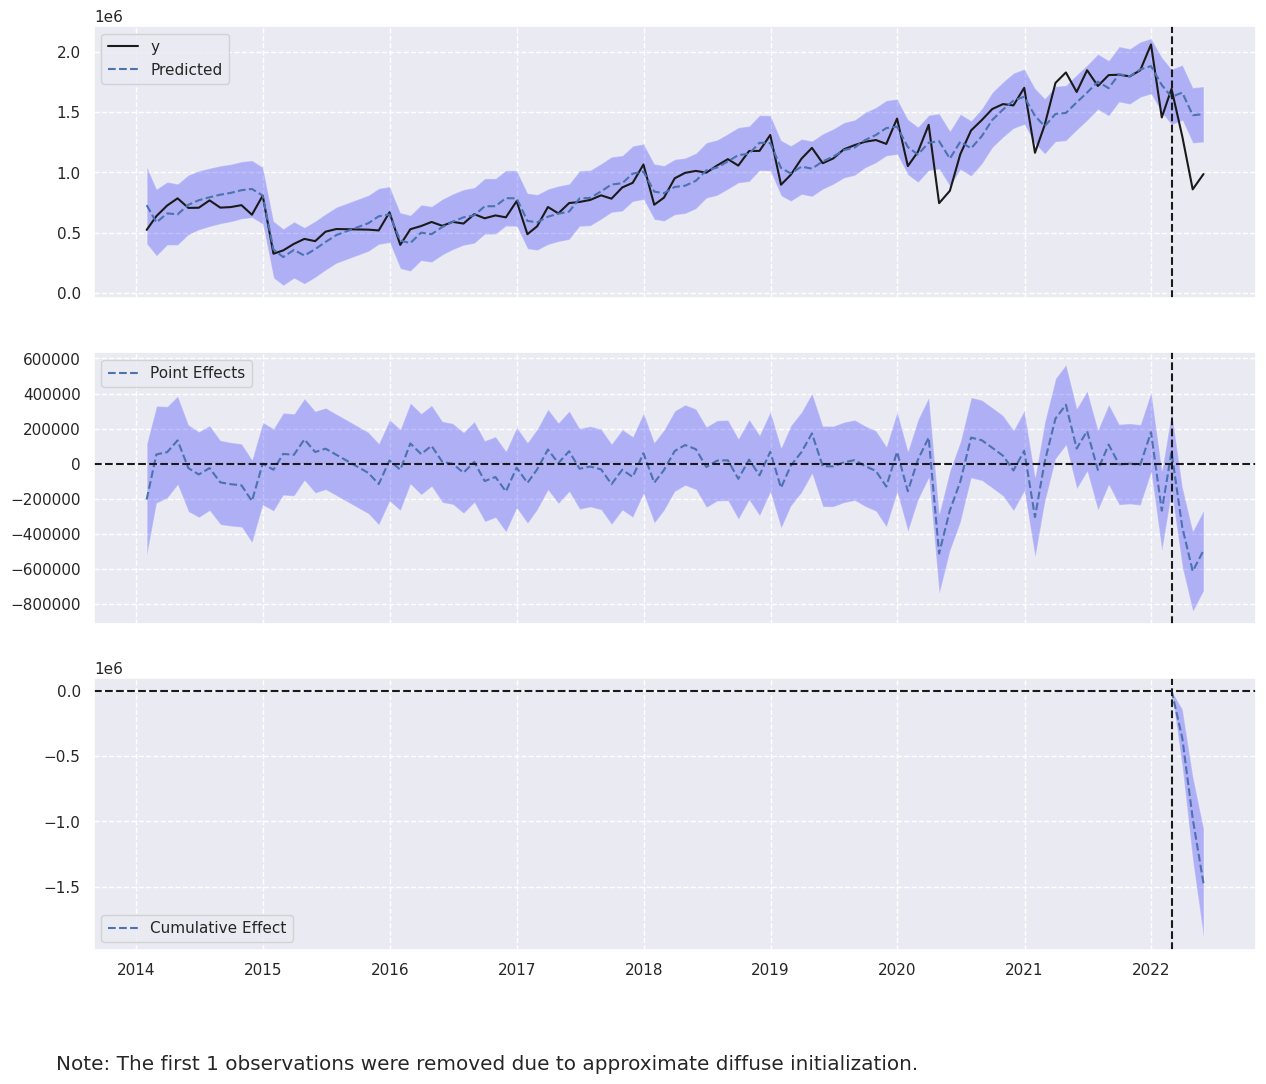

In [46]:
from causalimpact import CausalImpact
import warnings as w
w.filterwarnings('ignore')

training_start = '2013-12-31'
training_end = '2022-02-28'
treatment_start = '2022-03-31'
treatment_end = '2022-05-31'

impact = CausalImpact(
    train_data,
    pre_period = [training_start, training_end],
    post_period = [treatment_start, treatment_end]
)

# После того, как функция приняла наши
# данные и обучила линейную регрессию
# на периоде до возникновения события,
# мы можем построить графики с помощью следующей команды:

impact.plot();

In [48]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1047795.67         3143387.0
Prediction (s.d.)         1538883.6 (71042.55)4616650.79 (213127.64)
95% CI                    [1398625.64, 1677107.3][4195876.93, 5031321.91]

Absolute effect (s.d.)    -491087.93 (71042.55)-1473263.79 (213127.64)
95% CI                    [-629311.64, -350829.98][-1887934.91, -1052489.93]

Relative effect (s.d.)    -31.91% (4.62%)    -31.91% (4.62%)
95% CI                    [-40.89%, -22.8%]  [-40.89%, -22.8%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [49]:
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 1047795.67. By contrast, in the absence of an
intervention, we would have expected an average response of 1538883.6.
The 95% interval of this counterfactual prediction is [1398625.64, 1677107.3].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -491087.93 with a 95% interval of
[-629311.64, -350829.98]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 3143387.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 4616650.79. The 95% interval of this prediction is [4195876.93, 5031321.91].


The above results are given in terms of absolute